# Genetic Algorithm to solve the D-EVRP-NL
This notebook allows you to work with the implemented library and solve the Dynamic Electric Vehicle Routing Problem with Non-linear charging functions. The main purpose is to give good visualization of the solution and easy handling of network complexity.

## Initialization

First, import required libraries.

In [1]:
# Too work with arguments and script paths
import sys

# scientific libraries and tutilities
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt

# setup pyplot
conf = {'font.size': 20}
plt.rcParams.update(conf)

# GA library
from deap import base
from deap import creator
from deap import tools

# Visualization tools
from bokeh.plotting import figure, output_notebook, show
from bokeh.layouts import gridplot, column
from bokeh.layouts import row as layout_row
from bokeh.models.annotations import Arrow, Label
from bokeh.models.arrow_heads import OpenHead, NormalHead, VeeHead
from bokeh.models import ColumnDataSource, Div, Whisker, Span, Range1d
from bokeh.io import export_svgs, export_png

# Simulation environment tools
sys.path.append('..')
import res.EV_utilities
import res.GA_utilities_1

# Display useful loading of bokeh library and start timer
output_notebook()
t0 = time.time()

Loading BokehJS ...

The following are user-defined variables

In [2]:
# Network size and where are data files stored
networkSize = 70
folderPath = '../data/GA_implementation/'

# Charging stations points
chargingTimePoints = True
timePoints = [0.0, 40.0, 60., 120.]
socPoints = [0.0, 75.0, 90.0, 100.0]

# figure related
FIGURE_WIDTH = 800
FIGURE_HEIGHT = 500

figureFolderPath = "../data/GA_implementation/"+str(networkSize)+"network/"

The following implements some utility functions, not related to main GA

In [3]:
# %% Utilities
def shapeItems(items, shape=(None, 2)):
    numOfItems = len(items)
    columns = shape[1]

    if shape[0] is None:
        rows = int(numOfItems / columns) + int(numOfItems % columns)
    else:
        rows = shape[0]

    gridList = [[None] * columns for _ in range(0, rows)]

    i = 0
    j = 0
    for fig in items:
        if j == columns:
            i += 1
            j = 0
        gridList[i][j] = fig
        j += 1
    return gridList

## Import data
There are three main data files:
    - Time matrix: containing the time it takes to travel along arcs between each node
    - Energy matrix: cantaining the energy it takes to travel along arcs between each node
    - Info file: containing the information of each node

In [4]:
# %% Import time and energy matrices and show a value example

pathTM = folderPath + 'timeMatrix_' + str(networkSize) + 'nodes.csv'
timeMatrix = pd.read_csv(pathTM).set_index("TT(MIN)")

print('Time matrix:\n', timeMatrix, "\n")

pathEM = folderPath + 'energyMatrix_' + str(networkSize) + 'nodes.csv'
energyMatrix = pd.read_csv(pathEM).set_index("ENERGY(AH)")

print('Energy matrix:\n', energyMatrix, '\n')

# Indexing example
print("An index example...")
t = timeMatrix.iat[1, 2]
print("Travel time from 1 to 2: ", t)

e = energyMatrix.iat[1, 2]
print("Energy consumption from 1 to 2: ", e, '\n')


Time matrix:
                  0          1          2          3          4          5  \
TT(MIN)                                                                     
0         0.000000   8.356502  16.123209  14.836564  13.392616   9.867789   
1        14.960005   0.000000  13.535000  10.818365   8.083996  11.737020   
2        18.779469   8.607673   0.000000  19.689762   8.923815  10.009828   
3        19.752689  19.233880   8.754894   0.000000  12.713773  14.788688   
4        11.107851   9.119571  13.099216  15.048761   0.000000  11.073443   
5        13.569591  15.147919  15.652644  11.324876  15.046297   0.000000   
6        17.464498  10.461563  10.940352  11.138421  18.124205  19.835869   
7         8.545763  19.573603  10.955728  13.326397  12.548286   8.809506   
8        19.051816  19.126585  14.470572  10.025858  10.300224  14.314167   
9        19.708899  17.608126  19.607606  18.936274  15.412511   8.099018   
10       19.244528  16.888571   9.415239  17.135746  15.411688

In [5]:
# %% Import nodes information to differentiate among them

infoMatrix = pd.read_csv(folderPath + 'infoMatrix_' + str(networkSize) + 'nodes.csv')

depotDF = infoMatrix[infoMatrix['TYPE'] == 'DEPOT'].dropna(axis=1)
customerDF = infoMatrix[infoMatrix['TYPE'] == 'CUSTOMER'].dropna(axis=1)
csDF = infoMatrix[infoMatrix['TYPE'] == 'CS'].dropna(axis=1)

print('Depots DF:\n', depotDF, '\n')
print('Customers DF:\n', customerDF, '\n')
print('Charge Stations DF\n', csDF, '\n')


Depots DF:
    ID  POS_X  POS_Y   TYPE
0   0    0.0    0.0  DEPOT 

Customers DF:
     ID    DEMAND       POS_X       POS_Y  SERVICE_TIME  TIME_WINDOW_LOW  \
1    1  0.381097   14.813312  -29.273489      1.007486       678.736882   
2    2  0.408219  -97.029553   60.025620      2.248755       680.000000   
3    3  0.053798  -43.318305   69.830098      6.003728       623.356850   
4    4  0.233368   37.132541  133.453625      1.160810       697.072161   
5    5  0.302256  112.712082    0.849134      3.061553       629.976678   
6    6  0.461768  -64.212584 -109.112513      3.871720       600.470041   
7    7  0.487554 -102.013543  -66.565080      3.761231       605.271059   
8    8  0.096205  126.678949   54.553029      9.550936       611.281571   
9    9  0.220654  -37.589036   93.696398      2.562627       644.400828   
10  10  0.494580   64.787774   32.400054      7.623873       610.888516   
11  11  0.110390   31.492086  -36.891120      1.324521       651.483803   
12  12  0.191371 

## Create variables

In [6]:
# Create list with information

networkDict = {'DEPOT_LIST': [], 'CUSTOMER_LIST': [], 'CS_LIST': [],
               'TIME_MATRIX': timeMatrix, 'ENERGY_MATRIX': energyMatrix}

for _, row in depotDF.iterrows():
    networkDict[row['ID']] = res.EV_utilities.DepotNode(row['ID'])
    networkDict['DEPOT_LIST'].append(networkDict[row['ID']])

for _, row in customerDF.iterrows():
    networkDict[row['ID']] = res.EV_utilities.CustomerNode(row['ID'], row['SERVICE_TIME'], row['DEMAND'],
                                                           timeWindowUp=row['TIME_WINDOW_UP'],
                                                           timeWindowDown=row['TIME_WINDOW_LOW'])
    networkDict['CUSTOMER_LIST'].append(networkDict[row['ID']])

figureList = []

for _, row in csDF.iterrows():
    # Simple CS with linear curve
    if chargingTimePoints:
        networkDict[row['ID']] = res.EV_utilities.ChargeStationNode(row['ID'],
                                                                    timePoints=timePoints,
                                                                    socPoints=socPoints)
    else:
        networkDict[row['ID']] = res.EV_utilities.ChargeStationNode(row['ID'])

    networkDict['CS_LIST'].append(networkDict[row['ID']])
    # Append to show as grid
    s = figure(width=400, height=250, title='Charging function of CS ' + str(networkDict[row['ID']].id))

    s.xaxis.axis_label = 'Time (min)'
    s.yaxis.axis_label = 'SOC (%)'
    s.line(networkDict[row['ID']].timePoints, networkDict[row['ID']].socPoints, color='black', line_width=2)
    s.asterisk(networkDict[row['ID']].timePoints, networkDict[row['ID']].socPoints, color='black', size=10)
    
    # Save
    s.output_backend = "svg"
    export_svgs(s, filename=figureFolderPath+"CS"+str(row['ID'])+"_chargingFunction.svg")
    
    figureList.append(s)

# show grid
shapedFigs = shapeItems(figureList, shape=(None, 2))
p = gridplot(shapedFigs, toolbar_location='left')
show(p)


## Assign customers to each EV

In [7]:
# %% Number of cars and their random set to visit. Ensure that each one of them visit at least one

t1 = time.time()

nVehicles = 10
chooseCustomersRandom = True

vehiclesDict = {}

if chooseCustomersRandom:
    # Choose the customers each vehicle will visit randomly
    customersID = [evID for evID in customerDF['ID']]
    nCustomers = len(customersID)
    nCustomersPerCar = [int(nCustomers / nVehicles)] * nVehicles

    if len(customersID) % nVehicles != 0:
        nCustomersPerCar[-1] = int(len(customersID) / nVehicles) + 1

    for i, j in enumerate(nCustomersPerCar):
        print('Car', i, 'must visit', j, 'customer/s')
    print('\n')

    for carId, nCustomersCar in enumerate(nCustomersPerCar):
        carCustomersId = []
        for j in range(0, nCustomersCar):
            index = random.randint(0, len(customersID) - 1)
            carCustomersId.append(customersID.pop(index))
        customersToVisit = [customerId for customerId in carCustomersId]
        print('Car', carId, 'must visit customers with ID:', customersToVisit)

        nodeSequence = [0] + customersToVisit + [0]
        chargingSequence = [0] * len(nodeSequence)

        # instantiate
        Qi = 80.0
        x1 = 24.0 * 30.0
        sumDi = np.sum([networkDict[i].demand for i in nodeSequence])
        vehiclesDict[carId] = res.EV_utilities.ElectricVehicle(carId, customersToVisit, networkDict,
                                                               nodeSequence=nodeSequence,
                                                               chargingSequence=chargingSequence,
                                                               timeMatrix=timeMatrix.iat,
                                                               energyMatrix=energyMatrix.iat,
                                                               x1=x1, x2=Qi, x3=sumDi)
else:
    customersID = [[14,1,2,13,26,11,10,18],
                   [4,25,6,27,9,8,29],
                   [22,16,19,12,17,28],
                   [3,20,21,5,7,23]]
    for i, l in enumerate(customersID):
        print('Car',i,'must visit', len(l),'customers')
        
    nCustomers = sum([len(x) for x in customersID])

    for carId, customersToVisit in enumerate(customersID):
        print('Car', carId, 'must visit customers with ID:', customersToVisit)

        # IMPORTANT: the proposed nodeSequence
        nodeSequence = [0] + customersToVisit + [0]
        chargingSequence = [0] * len(nodeSequence)

        # instantiate
        Qi = 80.0
        sumDi = np.sum([networkDict[i].demand for i in nodeSequence])
        vehiclesDict[carId] = res.EV_utilities.ElectricVehicle(carId, customersToVisit, networkDict,
                                                               nodeSequence=nodeSequence,
                                                               chargingSequence=chargingSequence,
                                                               timeMatrix=timeMatrix.iat,
                                                               energyMatrix=energyMatrix.iat,
                                                               x2=Qi, x3=sumDi)


Car 0 must visit 6 customer/s
Car 1 must visit 6 customer/s
Car 2 must visit 6 customer/s
Car 3 must visit 6 customer/s
Car 4 must visit 6 customer/s
Car 5 must visit 6 customer/s
Car 6 must visit 6 customer/s
Car 7 must visit 6 customer/s
Car 8 must visit 6 customer/s
Car 9 must visit 7 customer/s


Car 0 must visit customers with ID: [21, 22, 38, 4, 15, 10]
Car 1 must visit customers with ID: [46, 64, 49, 66, 23, 2]
Car 2 must visit customers with ID: [30, 8, 9, 63, 11, 41]
Car 3 must visit customers with ID: [47, 48, 43, 26, 40, 54]
Car 4 must visit customers with ID: [5, 53, 39, 56, 55, 50]
Car 5 must visit customers with ID: [14, 44, 3, 37, 32, 13]
Car 6 must visit customers with ID: [17, 33, 25, 12, 20, 60]
Car 7 must visit customers with ID: [59, 34, 57, 36, 24, 18]
Car 8 must visit customers with ID: [29, 42, 58, 61, 52, 45]
Car 9 must visit customers with ID: [31, 1, 51, 65, 62, 7, 35]


 ## Setup GA

In [8]:
# %% Genetic algorithm

# allowed charging operations
numChargeOp = 2

# Build toolbox and useful classes
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Individual initializer
toolbox.register("individual", res.GA_utilities_1.createRandomIndividual, vehiclesDict,
                 allowed_charging_operations=numChargeOp)

# Fitness, crossover, mutation and selection
toolbox.register("evaluate", res.GA_utilities_1.fitness, vehiclesDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.register("mate", res.GA_utilities_1.crossover, vehiclesDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.register("mutate", res.GA_utilities_1.mutate, vehiclesDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.register("select", tools.selTournament, tournsize=3)

# Useful to decode
toolbox.register("decode", res.GA_utilities_1.decodeFunction, vehiclesDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)

# Constraint handling
toolbox.register("distance", res.GA_utilities_1.distanceToFeasibleZone, vehicleDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.register("feasible", res.GA_utilities_1.feasibleIndividual, vehicleDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.decorate("evaluate", tools.DeltaPenality(toolbox.feasible, -500000.0, toolbox.distance))

## Run GA

In [9]:
# %% the algorithm

tInitGA = time.time()
# Population TODO create function
n = 200
generations = 450

pop = []
for i in range(0, n):
    pop.append(creator.Individual(toolbox.individual()))

# CXPB  is the probability with which two individuals
#       are crossed
#
# MUTPB is the probability for mutating an individual
CXPB, MUTPB = 0.4, 0.4

print("################  Start of evolution  ################")

# Evaluate the entire population
# fitnesses = list(map(toolbox.evaluate, pop))

for ind in pop:
    fit = toolbox.evaluate(ind)
    ind.fitness.values = fit

print("  Evaluated %i individuals" % len(pop))

# Extracting all the fitnesses of
fits = [ind.fitness.values[0] for ind in pop]

# Variable keeping track of the number of generations
g = 0
Ymax = []
Ymin = []
Yavg = []
Ystd = []
X = []

bestOfAll = tools.selBest(pop, 1)[0]

# Begin the evolution
while g < generations:
    # A new generation
    g = g + 1
    X.append(g)
    print("-- Generation %i --" % g)

    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):

        # cross two individuals with probability CXPB
        if random.random() < CXPB:
            toolbox.mate(child1, child2)

            # fitness values of the children
            # must be recalculated later
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:

        # mutate an individual with probability MUTPB
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    for ind in invalid_ind:
        fit = toolbox.evaluate(ind)
        ind.fitness.values = fit

    print("  Evaluated %i individuals" % len(invalid_ind))

    # The population is entirely replaced by the offspring
    pop[:] = offspring

    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x * x for x in fits)
    std = abs(sum2 / length - mean ** 2) ** 0.5

    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)

    Ymax.append(-max(fits))
    Ymin.append(-min(fits))
    Yavg.append(mean)
    Ystd.append(std)

    bestInd = tools.selBest(pop, 1)[0]
    print("Best individual: ", bestInd)

    worstInd = tools.selWorst(pop, 1)[0]
    print("Worst individual: ", worstInd)

    # Save best ind
    if bestInd.fitness.values[0] > bestOfAll.fitness.values[0]:
        bestOfAll = bestInd

# %%
print("################  End of (successful) evolution  ################")


################  Start of evolution  ################
  Evaluated 200 individuals
-- Generation 1 --
  Evaluated 119 individuals
  Min -12495157.516640535
  Max -2258836.449856922
  Avg -6748867.315895972
  Std 2154599.186510303
Best individual:  [15, 10, 38, 4, 21, 22, -1, 0, 10.0, -1, 0, 10.0, 586, 66, 2, 49, 23, 46, 64, -1, 0, 10.0, -1, 0, 10.0, 509, 63, 11, 8, 9, 30, 41, -1, 0, 10.0, -1, 0, 10.0, 427, 47, 48, 40, 43, 54, 26, -1, 0, 10.0, -1, 0, 10.0, 1030, 50, 5, 39, 55, 53, 56, -1, 0, 10.0, -1, 0, 10.0, 681, 44, 32, 3, 13, 37, 14, -1, 0, 10.0, -1, 0, 10.0, 698, 33, 20, 60, 12, 25, 17, -1, 0, 10.0, -1, 0, 10.0, 335, 36, 34, 24, 57, 18, 59, -1, 0, 10.0, -1, 0, 10.0, 980, 58, 61, 52, 45, 42, 29, -1, 0, 10.0, -1, 0, 10.0, 755, 31, 7, 51, 1, 65, 35, 62, -1, 0, 10.0, -1, 0, 10.0, 576]
Worst individual:  [15, 10, 21, 38, 4, 22, -1, 0, 10.0, -1, 0, 10.0, 466, 66, 23, 46, 64, 49, 2, -1, 0, 10.0, -1, 0, 10.0, 176, 63, 30, 11, 41, 8, 9, -1, 0, 10.0, -1, 0, 10.0, 856, 54, 40, 48, 26, 47, 43,

  Evaluated 124 individuals
  Min -2393479.9697337174
  Max -1547098.2112586524
  Avg -2117955.185773036
  Std 201426.5145466362
Best individual:  [10, 22, 21, 4, 15, 38, -1, 0, 10.0, -1, 0, 10.0, 670, 49, 2, 46, 64, 66, 23, -1, 0, 10.0, -1, 0, 10.0, 671, 63, 9, 11, 8, 41, 30, -1, 0, 10.0, -1, 0, 10.0, 920, 54, 26, 47, 40, 48, 43, 54, 69, 9.15608281694845, -1, 0, 10.0, 712, 39, 5, 56, 53, 50, 55, -1, 0, 10.0, -1, 0, 10.0, 681, 3, 13, 14, 37, 32, 44, -1, 0, 10.0, -1, 0, 10.0, 853, 33, 60, 20, 25, 12, 17, -1, 0, 10.0, -1, 0, 10.0, 339, 36, 18, 57, 34, 59, 24, -1, 68, 38.72659636864573, -1, 0, 10.0, 715, 52, 42, 61, 58, 45, 29, -1, 0, 10.0, -1, 0, 10.0, 780, 51, 62, 7, 1, 31, 35, 65, -1, 0, 10.0, -1, 0, 10.0, 576]
Worst individual:  [15, 10, 38, 4, 21, 22, -1, 0, 10.0, -1, 0, 10.0, 586, 66, 2, 49, 23, 64, 46, -1, 0, 10.0, -1, 0, 10.0, 509, 63, 11, 8, 9, 30, 41, -1, 0, 10.0, -1, 0, 10.0, 427, 47, 48, 40, 43, 54, 26, -1, 0, 10.0, -1, 0, 10.0, 1030, 50, 5, 39, 55, 53, 56, -1, 0, 10.0, 50, 69

  Evaluated 126 individuals
  Min -1700324.0035267824
  Max -1311722.6858598166
  Avg -1519035.2927957056
  Std 40851.26121212286
Best individual:  [10, 22, 21, 4, 15, 38, -1, 0, 10.0, -1, 0, 10.0, 670, 49, 2, 23, 64, 66, 46, -1, 0, 10.0, -1, 0, 10.0, 671, 63, 9, 11, 8, 41, 30, -1, 0, 10.0, -1, 68, 10.445384907490244, 868.9189382587736, 54, 26, 47, 40, 48, 43, 54, 69, 9.15608281694845, -1, 0, 10.0, 712, 39, 5, 56, 53, 50, 55, -1, 0, 10.0, -1, 0, 10.0, 681, 3, 13, 14, 37, 32, 44, -1, 0, 10.0, -1, 0, 10.0, 853, 33, 60, 20, 25, 12, 17, -1, 0, 10.0, -1, 0, 10.0, 382.9890706568525, 36, 18, 57, 34, 59, 24, -1, 68, 38.72659636864573, -1, 0, 10.0, 715, 52, 61, 42, 45, 58, 29, -1, 0, 10.0, -1, 0, 10.0, 780, 51, 62, 7, 1, 31, 35, 65, -1, 0, 10.0, -1, 0, 10.0, 576]
Worst individual:  [10, 22, 21, 4, 15, 38, -1, 0, 10.0, -1, 0, 10.0, 670, 49, 2, 46, 64, 66, 23, -1, 0, 10.0, -1, 0, 10.0, 671, 63, 9, 11, 8, 41, 30, -1, 0, 10.0, -1, 0, 10.0, 920, 54, 26, 47, 40, 48, 43, -1, 68, 46.051399759287136, -1

  Evaluated 139 individuals
  Min -1469991.5916417001
  Max -1247453.331687001
  Avg -1311456.2704659814
  Std 24686.411181482825
Best individual:  [10, 22, 21, 4, 15, 38, -1, 68, 61.295538895323226, 10, 68, 17.23971142142203, 670, 49, 2, 23, 64, 66, 46, -1, 0, 10.0, -1, 0, 10.0, 671, 63, 9, 11, 8, 41, 30, -1, 0, 10.0, -1, 68, 10.445384907490244, 868.9189382587736, 54, 26, 47, 40, 48, 43, 54, 69, 9.15608281694845, -1, 0, 10.0, 712, 39, 5, 56, 53, 50, 55, -1, 0, 10.0, -1, 0, 10.0, 681, 3, 13, 14, 37, 32, 44, -1, 0, 10.0, -1, 0, 10.0, 853, 33, 60, 20, 25, 12, 17, 33, 68, 40.00198879494651, -1, 0, 10.0, 382.9890706568525, 36, 18, 57, 34, 59, 24, -1, 68, 38.72659636864573, -1, 0, 10.0, 715, 52, 61, 42, 45, 58, 29, -1, 0, 10.0, -1, 0, 10.0, 780, 51, 62, 7, 1, 35, 31, 65, -1, 0, 10.0, -1, 0, 10.0, 576]
Worst individual:  [10, 22, 21, 4, 15, 38, -1, 0, 10.0, -1, 0, 10.0, 670, 49, 2, 23, 64, 66, 46, -1, 0, 10.0, -1, 0, 10.0, 671, 63, 9, 11, 8, 41, 30, 63, 69, 31.290200106456997, -1, 68, 10.445

  Evaluated 123 individuals
  Min -1321707.885555666
  Max -1151184.8666116465
  Avg -1210336.1959058875
  Std 31552.178975408202
Best individual:  [10, 22, 21, 4, 15, 38, -1, 0, 10.0, -1, 0, 10.0, 670, 2, 64, 23, 49, 66, 46, -1, 0, 10.0, -1, 0, 10.0, 671, 63, 9, 11, 8, 41, 30, -1, 0, 10.0, -1, 68, 10.445384907490244, 850.3157265638522, 54, 26, 47, 40, 48, 43, 43, 69, 16.842005560928552, -1, 0, 10.0, 670.7438122777905, 39, 5, 56, 53, 50, 55, -1, 0, 10.0, -1, 0, 10.0, 681, 37, 13, 14, 3, 32, 44, -1, 0, 10.0, -1, 0, 10.0, 853, 33, 60, 20, 25, 12, 17, 33, 68, 40.00198879494651, -1, 0, 10.0, 382.9890706568525, 36, 18, 57, 34, 59, 24, -1, 68, 38.72659636864573, -1, 0, 10.0, 715, 52, 61, 42, 45, 58, 29, -1, 0, 10.0, -1, 0, 10.0, 772.5122329558201, 51, 62, 7, 1, 31, 35, 65, -1, 0, 10.0, -1, 0, 10.0, 579.8464285972109]
Worst individual:  [10, 22, 21, 38, 15, 4, -1, 68, 61.295538895323226, 10, 68, 17.23971142142203, 670, 49, 2, 23, 64, 66, 46, -1, 0, 10.0, -1, 0, 10.0, 671, 63, 9, 11, 8, 41, 30

  Evaluated 128 individuals
  Min -1249014.5285011167
  Max -1018805.907523309
  Avg -1133643.9337163821
  Std 31187.822893321605
Best individual:  [10, 22, 21, 4, 15, 38, -1, 0, 10.0, -1, 0, 10.0, 670, 2, 64, 23, 49, 66, 46, -1, 0, 10.0, -1, 0, 10.0, 671, 63, 9, 11, 8, 41, 30, -1, 0, 10.0, -1, 68, 10.445384907490244, 850.3157265638522, 54, 26, 47, 40, 48, 43, 43, 69, 16.842005560928552, -1, 0, 10.0, 670.7438122777905, 39, 5, 56, 53, 50, 55, -1, 0, 10.0, -1, 0, 10.0, 681, 37, 13, 14, 3, 32, 44, -1, 0, 10.0, -1, 0, 10.0, 853, 33, 60, 20, 25, 12, 17, 33, 68, 40.00198879494651, -1, 0, 10.0, 437.64159413533287, 57, 18, 36, 34, 59, 24, -1, 68, 38.72659636864573, -1, 0, 10.0, 715, 61, 52, 42, 45, 58, 29, -1, 0, 10.0, -1, 0, 10.0, 772.5122329558201, 65, 62, 7, 1, 31, 35, 51, 62, 68, 52.29067123613073, -1, 0, 10.0, 579.8464285972109]
Worst individual:  [10, 22, 21, 4, 15, 38, -1, 0, 10.0, -1, 0, 10.0, 670, 49, 64, 23, 2, 66, 46, -1, 0, 10.0, 2, 68, 41.918762496457674, 671, 8, 9, 11, 63, 41, 30

  Evaluated 139 individuals
  Min -1152005.3312282013
  Max -964610.2634700331
  Avg -1011300.7213378244
  Std 20229.884811820153
Best individual:  [10, 22, 38, 4, 15, 21, -1, 0, 10.0, -1, 0, 10.0, 670, 2, 64, 23, 49, 46, 66, -1, 0, 10.0, -1, 0, 10.0, 671, 63, 9, 11, 8, 41, 30, -1, 0, 10.0, -1, 68, 10.445384907490244, 800.6685598445463, 54, 26, 47, 40, 48, 43, 43, 69, 16.842005560928552, -1, 0, 10.0, 670.7438122777905, 39, 5, 56, 53, 50, 55, -1, 0, 10.0, -1, 0, 10.0, 681, 37, 13, 14, 3, 32, 44, -1, 0, 10.0, -1, 0, 10.0, 853, 33, 60, 20, 12, 25, 17, 33, 68, 40.00198879494651, -1, 0, 10.0, 437.64159413533287, 57, 18, 36, 34, 59, 24, -1, 68, 38.72659636864573, -1, 0, 10.0, 715, 52, 61, 42, 45, 58, 29, -1, 0, 10.0, -1, 0, 10.0, 772.5122329558201, 65, 62, 7, 1, 31, 35, 51, 7, 69, 40.86507548794102, -1, 0, 10.0, 579.8464285972109]
Worst individual:  [10, 22, 21, 4, 15, 38, -1, 0, 10.0, -1, 0, 10.0, 670, 2, 64, 23, 49, 66, 46, -1, 0, 10.0, -1, 0, 10.0, 671, 8, 9, 11, 63, 41, 30, -1, 0, 10.0, 

  Evaluated 135 individuals
  Min -1056828.4317515697
  Max -858961.4825098586
  Avg -952584.1919304836
  Std 23328.030394483318
Best individual:  [10, 22, 4, 21, 15, 38, -1, 0, 10.0, -1, 0, 10.0, 670, 46, 64, 23, 49, 66, 2, -1, 0, 10.0, -1, 0, 10.0, 671, 63, 9, 11, 8, 41, 30, -1, 0, 10.0, -1, 68, 10.445384907490244, 800.1192056163375, 54, 26, 47, 48, 40, 43, 43, 69, 16.842005560928552, -1, 0, 10.0, 670.7438122777905, 39, 5, 56, 53, 50, 55, -1, 0, 10.0, -1, 0, 10.0, 681, 37, 13, 14, 3, 32, 44, -1, 0, 10.0, -1, 0, 10.0, 796.6437868676649, 33, 60, 20, 25, 12, 17, 33, 68, 40.00198879494651, -1, 0, 10.0, 437.64159413533287, 57, 18, 36, 24, 59, 34, -1, 68, 38.72659636864573, -1, 0, 10.0, 715, 52, 61, 42, 45, 58, 29, -1, 0, 10.0, -1, 0, 10.0, 772.5122329558201, 62, 65, 7, 1, 31, 35, 51, -1, 0, 10.0, -1, 0, 10.0, 579.8464285972109]
Worst individual:  [10, 22, 21, 4, 15, 38, -1, 0, 10.0, -1, 0, 10.0, 670, 46, 64, 23, 49, 66, 2, -1, 0, 10.0, -1, 0, 10.0, 671, 63, 9, 11, 8, 41, 30, -1, 0, 10.0, 

  Evaluated 131 individuals
  Min -925712.9739109874
  Max -800122.1345275125
  Avg -850162.7707321821
  Std 11002.910685284138
Best individual:  [10, 38, 4, 21, 15, 22, -1, 0, 10.0, -1, 0, 10.0, 670, 46, 64, 23, 49, 66, 2, -1, 0, 10.0, -1, 0, 10.0, 671, 63, 9, 11, 8, 41, 30, -1, 0, 10.0, -1, 68, 10.445384907490244, 800.1192056163375, 54, 26, 47, 48, 40, 43, 43, 69, 16.842005560928552, -1, 0, 10.0, 670.7438122777905, 39, 5, 56, 53, 50, 55, -1, 0, 10.0, -1, 0, 10.0, 681, 37, 13, 14, 3, 32, 44, -1, 0, 10.0, -1, 0, 10.0, 753.8621811608921, 33, 60, 20, 25, 12, 17, 33, 68, 40.00198879494651, -1, 0, 10.0, 437.64159413533287, 57, 18, 36, 24, 59, 34, -1, 68, 70.74710377095693, -1, 0, 10.0, 715, 52, 61, 42, 45, 58, 29, -1, 0, 10.0, -1, 0, 10.0, 772.5122329558201, 62, 65, 7, 1, 31, 35, 51, -1, 0, 10.0, -1, 0, 10.0, 579.8464285972109]
Worst individual:  [10, 22, 4, 21, 15, 38, -1, 0, 10.0, -1, 0, 10.0, 670, 46, 64, 23, 49, 66, 2, -1, 0, 10.0, -1, 0, 10.0, 671, 63, 9, 11, 8, 41, 30, -1, 0, 10.0, 6

  Evaluated 121 individuals
  Min -848956.9267043467
  Max -718921.144901346
  Avg -791751.3204790786
  Std 20524.50718007288
Best individual:  [10, 38, 4, 21, 15, 22, -1, 0, 10.0, -1, 0, 10.0, 670, 46, 64, 23, 2, 66, 49, -1, 0, 10.0, -1, 0, 10.0, 671, 63, 9, 11, 8, 41, 30, -1, 0, 10.0, -1, 68, 10.445384907490244, 800.1192056163375, 54, 26, 47, 48, 40, 43, 43, 69, 16.842005560928552, -1, 0, 10.0, 670.7438122777905, 39, 5, 56, 53, 50, 55, -1, 0, 10.0, -1, 0, 10.0, 681, 37, 13, 14, 3, 32, 44, -1, 0, 10.0, -1, 0, 10.0, 753.8621811608921, 33, 60, 20, 25, 12, 17, 33, 68, 40.00198879494651, -1, 0, 10.0, 495.8300676329212, 57, 18, 36, 24, 59, 34, -1, 68, 70.74710377095693, -1, 0, 10.0, 715, 52, 61, 42, 45, 58, 29, -1, 0, 10.0, -1, 0, 10.0, 772.5122329558201, 62, 65, 7, 1, 31, 35, 51, -1, 0, 10.0, -1, 0, 10.0, 579.8464285972109]
Worst individual:  [10, 22, 4, 21, 15, 38, -1, 0, 10.0, -1, 0, 10.0, 670, 46, 64, 23, 49, 66, 2, -1, 0, 10.0, -1, 0, 10.0, 671, 63, 9, 11, 8, 41, 30, -1, 0, 10.0, -1, 

  Evaluated 139 individuals
  Min -755494.0801066002
  Max -666335.4365083305
  Avg -711398.074928556
  Std 12933.40304668895
Best individual:  [10, 38, 4, 22, 15, 21, -1, 0, 10.0, -1, 0, 10.0, 670, 46, 64, 23, 49, 66, 2, -1, 0, 10.0, -1, 0, 10.0, 671, 63, 9, 11, 30, 41, 8, -1, 0, 10.0, -1, 68, 10.445384907490244, 748.1709312240965, 54, 26, 47, 48, 40, 43, 43, 69, 16.842005560928552, -1, 0, 10.0, 670.7438122777905, 39, 5, 56, 53, 50, 55, -1, 0, 10.0, -1, 0, 10.0, 681, 37, 13, 14, 3, 32, 44, -1, 0, 10.0, 44, 68, 87.07090933052989, 717.5361339749587, 33, 60, 20, 25, 12, 17, 33, 68, 40.00198879494651, -1, 68, 19.127761488470007, 495.8300676329212, 57, 18, 36, 24, 59, 34, -1, 68, 70.74710377095693, -1, 0, 10.0, 715, 52, 61, 42, 45, 58, 29, -1, 0, 10.0, -1, 0, 10.0, 772.5122329558201, 62, 65, 7, 1, 31, 35, 51, -1, 0, 10.0, -1, 0, 10.0, 579.8464285972109]
Worst individual:  [10, 38, 4, 21, 15, 22, -1, 0, 10.0, -1, 0, 10.0, 670, 46, 64, 23, 2, 66, 49, 64, 69, 4.678814045825109, -1, 0, 10.0, 6

  Evaluated 142 individuals
  Min -743754.4500152499
  Max -621746.8191988296
  Avg -664103.7280393066
  Std 12343.932037470513
Best individual:  [10, 38, 4, 22, 15, 21, -1, 0, 10.0, -1, 0, 10.0, 670, 46, 64, 23, 49, 66, 2, -1, 0, 10.0, -1, 0, 10.0, 671, 63, 9, 11, 30, 41, 8, -1, 0, 10.0, -1, 68, 10.445384907490244, 748.1709312240965, 54, 26, 47, 48, 40, 43, 43, 69, 16.842005560928552, -1, 0, 10.0, 670.7438122777905, 39, 5, 56, 53, 50, 55, -1, 0, 10.0, -1, 0, 10.0, 681, 37, 13, 14, 3, 32, 44, -1, 0, 10.0, 44, 68, 87.07090933052989, 717.5361339749587, 33, 60, 20, 25, 12, 17, 33, 68, 40.00198879494651, -1, 68, 19.127761488470007, 553.6830290425014, 57, 18, 36, 24, 59, 34, -1, 68, 70.74710377095693, -1, 0, 10.0, 715, 52, 61, 42, 45, 58, 29, -1, 0, 10.0, -1, 0, 10.0, 772.5122329558201, 62, 65, 7, 1, 31, 35, 51, -1, 0, 10.0, -1, 0, 10.0, 579.8464285972109]
Worst individual:  [10, 38, 4, 21, 15, 22, -1, 0, 10.0, -1, 0, 10.0, 670, 46, 64, 23, 2, 66, 49, -1, 68, 52.526903276374085, -1, 0, 10.0

  Evaluated 131 individuals
  Min -691458.841825389
  Max -596895.3209082901
  Avg -619195.1983890801
  Std 11090.316544113834
Best individual:  [10, 38, 4, 21, 15, 22, -1, 0, 10.0, -1, 0, 10.0, 670, 46, 64, 23, 49, 66, 2, -1, 0, 10.0, -1, 0, 10.0, 671, 63, 9, 11, 8, 30, 41, -1, 0, 10.0, -1, 68, 10.445384907490244, 748.1726928314307, 54, 26, 47, 48, 40, 43, 43, 69, 16.842005560928552, -1, 0, 10.0, 670.7438122777905, 5, 56, 39, 53, 50, 55, -1, 0, 10.0, -1, 0, 10.0, 681, 37, 13, 14, 3, 32, 44, -1, 0, 10.0, 44, 68, 87.07090933052989, 703.78958794939, 20, 17, 33, 25, 12, 60, 33, 68, 40.00198879494651, -1, 0, 10.0, 528.6699243328032, 57, 18, 36, 24, 59, 34, -1, 68, 70.74710377095693, -1, 0, 10.0, 715, 58, 61, 42, 45, 52, 29, -1, 0, 10.0, -1, 0, 10.0, 727.7657991742641, 62, 65, 7, 1, 31, 35, 51, -1, 0, 10.0, -1, 0, 10.0, 579.8464285972109]
Worst individual:  [10, 38, 4, 22, 15, 21, -1, 0, 10.0, -1, 0, 10.0, 670, 46, 64, 23, 49, 66, 2, -1, 0, 10.0, -1, 0, 10.0, 671, 63, 9, 11, 30, 41, 8, -1, 

  Evaluated 127 individuals
  Min -660809.7898660859
  Max -574387.4604967921
  Avg -594513.8669534259
  Std 10493.239331803097
Best individual:  [10, 38, 4, 22, 15, 21, -1, 0, 10.0, -1, 0, 10.0, 670, 46, 64, 23, 2, 66, 49, -1, 0, 10.0, -1, 0, 10.0, 671, 63, 9, 11, 30, 41, 8, -1, 0, 10.0, -1, 68, 10.445384907490244, 748.1709312240965, 54, 26, 47, 48, 40, 43, 43, 69, 16.842005560928552, -1, 0, 10.0, 670.7438122777905, 39, 5, 56, 53, 50, 55, -1, 0, 10.0, -1, 0, 10.0, 681, 37, 13, 14, 3, 32, 44, -1, 0, 10.0, 44, 68, 87.07090933052989, 688.1608781378136, 33, 60, 20, 25, 12, 17, 33, 68, 40.00198879494651, -1, 68, 19.127761488470007, 553.6830290425014, 57, 18, 36, 24, 59, 34, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 715, 58, 61, 42, 45, 29, 52, -1, 0, 10.0, -1, 0, 10.0, 737.745965946748, 62, 65, 7, 1, 31, 35, 51, -1, 0, 10.0, -1, 69, 59.57655629821978, 579.8464285972109]
Worst individual:  [10, 38, 4, 22, 15, 21, -1, 0, 10.0, -1, 0, 10.0, 670, 46, 64, 23, 2, 66, 49, -1, 0, 10.0

  Evaluated 129 individuals
  Min -622590.640642132
  Max -564369.6165649933
  Avg -575832.0659505292
  Std 8387.701027620593
Best individual:  [10, 38, 4, 22, 15, 21, -1, 0, 10.0, -1, 0, 10.0, 670, 46, 64, 23, 2, 66, 49, -1, 0, 10.0, -1, 0, 10.0, 671, 63, 9, 11, 30, 41, 8, -1, 0, 10.0, -1, 68, 10.445384907490244, 698.2245738860383, 54, 26, 47, 48, 40, 43, 43, 69, 16.842005560928552, -1, 0, 10.0, 670.7438122777905, 39, 5, 56, 53, 50, 55, -1, 0, 10.0, -1, 0, 10.0, 681, 37, 13, 14, 3, 32, 44, -1, 0, 10.0, 44, 68, 87.07090933052989, 688.1608781378136, 33, 60, 20, 25, 12, 17, 33, 68, 40.00198879494651, -1, 68, 19.127761488470007, 553.6830290425014, 57, 18, 36, 24, 59, 34, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 715, 58, 61, 42, 45, 29, 52, -1, 0, 10.0, -1, 0, 10.0, 737.745965946748, 62, 65, 7, 1, 31, 35, 51, -1, 0, 10.0, -1, 69, 59.57655629821978, 579.8464285972109]
Worst individual:  [10, 38, 4, 22, 15, 21, -1, 0, 10.0, -1, 0, 10.0, 670, 46, 64, 23, 2, 66, 49, -1, 0, 10.0, 

  Evaluated 131 individuals
  Min -619296.5811221557
  Max -553038.8280217939
  Avg -562979.6502262413
  Std 8250.00215406725
Best individual:  [10, 38, 4, 22, 15, 21, -1, 0, 10.0, -1, 0, 10.0, 670, 46, 64, 23, 2, 66, 49, -1, 0, 10.0, -1, 0, 10.0, 671, 63, 9, 11, 30, 41, 8, -1, 0, 10.0, -1, 68, 10.445384907490244, 689.4952796535853, 54, 26, 47, 48, 40, 43, 43, 69, 16.842005560928552, -1, 0, 10.0, 670.7438122777905, 39, 5, 56, 53, 50, 55, -1, 0, 10.0, -1, 0, 10.0, 681, 37, 13, 14, 3, 32, 44, -1, 0, 10.0, -1, 69, 60.977282435442966, 688.1608781378136, 17, 60, 20, 33, 12, 25, 33, 68, 40.00198879494651, -1, 68, 19.127761488470007, 553.6830290425014, 57, 18, 34, 24, 59, 36, -1, 68, 48.785276596306566, -1, 69, 58.017138003833225, 715, 58, 61, 42, 45, 29, 52, -1, 0, 10.0, -1, 0, 10.0, 737.745965946748, 62, 65, 7, 1, 31, 35, 51, -1, 0, 10.0, -1, 69, 59.57655629821978, 579.8464285972109]
Worst individual:  [10, 38, 4, 22, 15, 21, -1, 0, 10.0, -1, 0, 10.0, 670, 46, 64, 23, 2, 66, 49, -1, 0, 10.0

  Evaluated 141 individuals
  Min -582989.6522519221
  Max -540028.5477715193
  Avg -552410.62399446
  Std 6240.037771355191
Best individual:  [10, 38, 4, 22, 15, 21, -1, 0, 10.0, -1, 0, 10.0, 670, 46, 64, 23, 2, 66, 49, -1, 0, 10.0, -1, 0, 10.0, 671, 63, 9, 11, 30, 41, 8, -1, 0, 10.0, -1, 68, 10.445384907490244, 698.2245738860383, 54, 26, 47, 48, 40, 43, 43, 69, 16.842005560928552, -1, 0, 10.0, 670.7438122777905, 39, 5, 56, 53, 50, 55, -1, 0, 10.0, -1, 0, 10.0, 681, 37, 13, 14, 3, 32, 44, -1, 0, 10.0, 44, 68, 87.07090933052989, 688.1608781378136, 12, 60, 20, 25, 33, 17, 33, 68, 40.00198879494651, -1, 68, 19.127761488470007, 598.2778189025923, 57, 18, 36, 24, 59, 34, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 715, 61, 58, 42, 45, 29, 52, -1, 0, 10.0, -1, 0, 10.0, 737.745965946748, 62, 65, 7, 1, 31, 35, 51, -1, 0, 10.0, -1, 69, 59.57655629821978, 579.8464285972109]
Worst individual:  [10, 38, 4, 22, 15, 21, 10, 68, 88.86310799570272, -1, 0, 10.0, 670, 46, 64, 23, 2, 66, 49, 

  Evaluated 114 individuals
  Min -568431.6352533499
  Max -528398.5221198364
  Avg -539883.2443037466
  Std 4624.308053958481
Best individual:  [10, 38, 4, 22, 15, 21, -1, 0, 10.0, -1, 0, 10.0, 670, 46, 64, 23, 2, 66, 49, -1, 0, 10.0, -1, 68, 22.512014781026192, 671, 63, 9, 11, 30, 41, 8, -1, 0, 10.0, -1, 68, 10.445384907490244, 698.2245738860383, 54, 26, 47, 48, 40, 43, 43, 69, 16.842005560928552, -1, 0, 10.0, 670.7438122777905, 39, 5, 56, 53, 50, 55, -1, 0, 10.0, -1, 0, 10.0, 681, 37, 13, 14, 3, 32, 44, -1, 0, 10.0, -1, 69, 60.977282435442966, 688.1608781378136, 12, 60, 20, 25, 33, 17, 60, 68, 17.301730653648246, -1, 68, 19.127761488470007, 598.2778189025923, 57, 18, 36, 24, 59, 34, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 715, 58, 61, 42, 45, 29, 52, -1, 0, 10.0, -1, 0, 10.0, 679.2141881467512, 62, 65, 7, 1, 31, 35, 51, 51, 69, 10.044488924338289, -1, 69, 59.57655629821978, 579.8464285972109]
Worst individual:  [10, 38, 4, 22, 15, 21, -1, 0, 10.0, -1, 0, 10.0, 670, 46

  Evaluated 120 individuals
  Min -550583.4826919921
  Max -523605.3763864056
  Avg -529815.2060846201
  Std 3854.2902495239878
Best individual:  [10, 38, 4, 22, 15, 21, -1, 0, 10.0, -1, 0, 10.0, 670, 46, 64, 23, 2, 66, 49, -1, 0, 10.0, -1, 68, 22.512014781026192, 671, 63, 9, 11, 30, 41, 8, -1, 0, 10.0, -1, 68, 10.445384907490244, 698.2245738860383, 54, 26, 47, 48, 40, 43, 43, 69, 16.842005560928552, -1, 0, 10.0, 670.7438122777905, 39, 5, 56, 53, 50, 55, -1, 0, 10.0, -1, 0, 10.0, 681, 37, 13, 14, 3, 32, 44, -1, 0, 10.0, -1, 69, 60.977282435442966, 688.1608781378136, 12, 60, 20, 25, 33, 17, 60, 68, 17.301730653648246, -1, 68, 19.127761488470007, 598.2778189025923, 34, 18, 36, 24, 59, 57, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 715, 58, 61, 42, 45, 29, 52, -1, 0, 10.0, -1, 68, 66.32004025617566, 679.2141881467512, 62, 65, 7, 1, 31, 35, 51, -1, 69, 64.70335074170568, -1, 69, 59.57655629821978, 579.8464285972109]
Worst individual:  [10, 38, 4, 22, 15, 21, -1, 0, 10.0, -1, 0,

  Evaluated 125 individuals
  Min -557603.8130612292
  Max -518332.4493391543
  Avg -523730.1717835201
  Std 4528.293677080254
Best individual:  [10, 38, 4, 22, 15, 21, -1, 0, 10.0, -1, 0, 10.0, 670, 46, 64, 23, 2, 66, 49, -1, 0, 10.0, -1, 68, 12.030343724201245, 646.7319181999778, 63, 8, 11, 30, 41, 9, -1, 0, 10.0, -1, 68, 10.445384907490244, 698.2245738860383, 48, 26, 47, 54, 40, 43, 43, 69, 16.842005560928552, -1, 0, 10.0, 670.7438122777905, 39, 5, 56, 53, 50, 55, -1, 0, 10.0, -1, 0, 10.0, 681, 37, 13, 14, 3, 32, 44, -1, 0, 10.0, -1, 69, 60.977282435442966, 688.1608781378136, 12, 60, 20, 25, 33, 17, 60, 68, 17.301730653648246, -1, 68, 19.127761488470007, 598.2778189025923, 57, 18, 36, 24, 59, 34, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 686.0512570123473, 58, 61, 42, 45, 29, 52, -1, 0, 10.0, -1, 69, 48.163997461770975, 679.2141881467512, 62, 65, 7, 1, 31, 35, 51, 51, 69, 10.044488924338289, -1, 69, 59.57655629821978, 579.8464285972109]
Worst individual:  [10, 38, 4, 22

  Evaluated 116 individuals
  Min -550741.1975736028
  Max -513858.2565092984
  Avg -518257.51233852265
  Std 3713.663611375838
Best individual:  [10, 38, 4, 22, 15, 21, -1, 68, 7.81817840955202, -1, 0, 10.0, 670, 46, 64, 23, 2, 66, 49, -1, 0, 10.0, -1, 68, 22.512014781026192, 671, 63, 9, 11, 30, 41, 8, -1, 0, 10.0, -1, 68, 10.445384907490244, 698.2245738860383, 48, 26, 47, 54, 40, 43, 43, 69, 16.842005560928552, -1, 0, 10.0, 670.7438122777905, 39, 5, 56, 53, 50, 55, -1, 0, 10.0, -1, 0, 10.0, 681, 37, 13, 14, 3, 32, 44, -1, 0, 10.0, -1, 69, 60.977282435442966, 653.0623268389573, 12, 60, 20, 25, 33, 17, 12, 69, 21.37327499406516, -1, 68, 19.127761488470007, 598.2778189025923, 34, 18, 36, 24, 59, 57, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 715, 58, 61, 42, 45, 29, 52, -1, 0, 10.0, -1, 69, 48.163997461770975, 679.2141881467512, 35, 65, 7, 1, 31, 62, 51, -1, 69, 64.70335074170568, -1, 69, 59.57655629821978, 579.8464285972109]
Worst individual:  [10, 38, 4, 22, 15, 21, -1, 68

  Evaluated 116 individuals
  Min -552715.2414051042
  Max -508225.001043377
  Avg -513794.9845275595
  Std 4211.735583331576
Best individual:  [10, 38, 4, 22, 15, 21, -1, 68, 7.81817840955202, -1, 0, 10.0, 670, 46, 64, 23, 2, 66, 49, 23, 68, 1.7336668718681392, -1, 68, 22.512014781026192, 671, 63, 9, 11, 30, 41, 8, -1, 0, 10.0, -1, 68, 10.445384907490244, 698.2245738860383, 54, 26, 47, 48, 40, 43, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 39, 5, 56, 53, 50, 55, -1, 0, 10.0, -1, 0, 10.0, 681, 37, 13, 14, 3, 32, 44, -1, 0, 10.0, -1, 69, 64.15843976430183, 653.0623268389573, 12, 60, 20, 25, 33, 17, 60, 68, 17.301730653648246, -1, 68, 19.127761488470007, 627.4423449722555, 34, 18, 24, 36, 59, 57, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 715, 58, 61, 42, 45, 29, 52, -1, 0, 10.0, -1, 69, 48.163997461770975, 679.2141881467512, 35, 65, 7, 1, 31, 62, 51, -1, 69, 64.70335074170568, -1, 69, 59.57655629821978, 596.7577943686466]
Worst individual:  [10, 38, 4, 22, 15

  Evaluated 127 individuals
  Min -541867.458001677
  Max -505271.92115637247
  Avg -509195.56124337844
  Std 4431.277710731712
Best individual:  [10, 38, 21, 22, 15, 4, -1, 68, 7.81817840955202, -1, 0, 10.0, 670, 46, 64, 23, 2, 66, 49, 23, 68, 1.7336668718681392, -1, 68, 22.512014781026192, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 10.445384907490244, 698.2245738860383, 54, 26, 47, 48, 40, 43, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 39, 5, 56, 53, 50, 55, -1, 0, 10.0, -1, 0, 10.0, 681, 37, 13, 14, 3, 32, 44, -1, 68, 33.43367917626931, -1, 69, 60.977282435442966, 653.0623268389573, 12, 60, 20, 25, 33, 17, 60, 68, 17.301730653648246, -1, 68, 19.127761488470007, 627.4423449722555, 34, 18, 24, 36, 59, 57, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 715, 58, 61, 42, 45, 29, 52, -1, 0, 10.0, -1, 69, 48.163997461770975, 679.2141881467512, 35, 65, 7, 1, 31, 62, 51, -1, 69, 64.70335074170568, -1, 69, 59.57655629821978, 596.7577943686466]
Worst individual:  [

  Evaluated 135 individuals
  Min -546093.0842071493
  Max -503241.21019922395
  Avg -506302.665378858
  Std 3991.8256013842156
Best individual:  [10, 38, 21, 22, 15, 4, -1, 68, 7.81817840955202, -1, 0, 10.0, 670, 23, 64, 46, 2, 66, 49, 23, 68, 1.7336668718681392, -1, 68, 22.512014781026192, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 10.445384907490244, 698.2245738860383, 54, 26, 47, 48, 40, 43, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 39, 5, 56, 53, 50, 55, -1, 69, 36.348234352532295, -1, 0, 10.0, 681, 37, 13, 14, 3, 32, 44, -1, 68, 33.43367917626931, -1, 69, 60.977282435442966, 653.0623268389573, 12, 60, 20, 25, 33, 17, 12, 69, 21.37327499406516, -1, 68, 19.127761488470007, 627.4423449722555, 34, 18, 24, 36, 59, 57, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 715, 58, 61, 42, 45, 29, 52, -1, 0, 10.0, -1, 69, 48.163997461770975, 679.2141881467512, 35, 65, 7, 1, 31, 62, 51, -1, 69, 64.70335074170568, -1, 69, 59.57655629821978, 596.7577943686466]
Worst 

  Evaluated 126 individuals
  Min -542469.4251712959
  Max -502274.16513146425
  Avg -504542.18269559776
  Std 4844.040928911065
Best individual:  [10, 38, 21, 22, 15, 4, -1, 68, 7.81817840955202, -1, 0, 10.0, 670, 23, 64, 46, 2, 66, 49, 23, 68, 1.7336668718681392, -1, 68, 22.512014781026192, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 10.445384907490244, 698.2245738860383, 54, 26, 47, 48, 40, 43, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 39, 5, 53, 56, 50, 55, -1, 69, 36.348234352532295, -1, 0, 10.0, 664.9854842203846, 37, 13, 14, 3, 32, 44, -1, 0, 10.0, -1, 69, 60.977282435442966, 653.0623268389573, 12, 60, 20, 25, 33, 17, 60, 68, 17.301730653648246, -1, 68, 19.127761488470007, 652.84428520688, 34, 24, 18, 36, 59, 57, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 715, 58, 61, 42, 45, 29, 52, -1, 0, 10.0, -1, 69, 48.163997461770975, 679.2141881467512, 35, 65, 7, 1, 31, 62, 51, -1, 69, 64.70335074170568, -1, 69, 59.57655629821978, 596.7577943686466]
Worst 

  Evaluated 121 individuals
  Min -516139.42513742356
  Max -502058.13971171674
  Avg -502968.2116006943
  Std 1486.2983167489795
Best individual:  [38, 10, 21, 22, 15, 4, -1, 68, 7.81817840955202, -1, 0, 10.0, 670, 23, 64, 46, 2, 66, 49, 23, 68, 1.7336668718681392, -1, 68, 22.512014781026192, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 10.445384907490244, 698.2245738860383, 54, 26, 47, 48, 40, 43, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 39, 5, 56, 53, 50, 55, -1, 69, 36.348234352532295, -1, 0, 10.0, 681, 37, 13, 14, 3, 32, 44, -1, 68, 33.43367917626931, -1, 69, 60.977282435442966, 653.0623268389573, 12, 60, 20, 25, 33, 17, 12, 69, 21.37327499406516, -1, 68, 19.127761488470007, 627.4423449722555, 34, 24, 18, 36, 59, 57, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 715, 58, 61, 42, 45, 29, 52, -1, 0, 10.0, -1, 69, 48.163997461770975, 679.2141881467512, 35, 65, 7, 1, 31, 62, 51, -1, 69, 64.70335074170568, -1, 69, 59.57655629821978, 596.7577943686466]
Wors

  Evaluated 147 individuals
  Min -539107.020559682
  Max -501544.7148850797
  Avg -502999.13988163613
  Std 3498.147548693511
Best individual:  [38, 10, 21, 22, 15, 4, -1, 68, 7.81817840955202, -1, 0, 10.0, 670, 23, 2, 46, 64, 66, 49, 23, 68, 1.7336668718681392, -1, 68, 22.512014781026192, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 10.445384907490244, 698.2245738860383, 54, 26, 47, 48, 40, 43, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 39, 5, 53, 56, 50, 55, -1, 68, 80.00785782018367, -1, 0, 10.0, 664.9854842203846, 37, 13, 14, 3, 32, 44, -1, 69, 71.23689937517189, -1, 69, 60.977282435442966, 653.0623268389573, 12, 60, 20, 25, 33, 17, 60, 68, 17.301730653648246, -1, 68, 19.127761488470007, 652.84428520688, 34, 24, 18, 36, 59, 57, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 715, 58, 61, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 69, 48.163997461770975, 679.2141881467512, 35, 65, 7, 1, 31, 62, 51, -1, 69, 64.70335074170568, -1, 69, 59.57655629821978, 

  Evaluated 129 individuals
  Min -523567.98052891303
  Max -500308.2827670419
  Avg -501877.74054153234
  Std 2078.742084095851
Best individual:  [38, 10, 21, 22, 15, 4, -1, 68, 7.81817840955202, -1, 0, 10.0, 670, 23, 2, 46, 64, 66, 49, 46, 68, 11.330738901347912, -1, 68, 22.512014781026192, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 25.75835953286745, 698.2245738860383, 48, 26, 43, 54, 47, 40, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 39, 5, 53, 56, 50, 55, -1, 68, 80.00785782018367, -1, 0, 10.0, 664.9854842203846, 37, 13, 14, 3, 32, 44, -1, 0, 10.0, -1, 69, 60.977282435442966, 653.0623268389573, 12, 60, 20, 25, 33, 17, 60, 68, 17.301730653648246, -1, 68, 19.127761488470007, 652.84428520688, 34, 24, 18, 36, 59, 57, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 715, 58, 61, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 35, 65, 7, 1, 31, 62, 51, -1, 69, 64.70335074170568, -1, 69, 59.57655629821978, 596.75779436864

  Evaluated 130 individuals
  Min -521540.879310024
  Max -500140.8784436023
  Avg -501279.6772114269
  Std 2946.1905134175076
Best individual:  [38, 10, 21, 22, 15, 4, -1, 68, 7.81817840955202, -1, 0, 10.0, 670, 23, 2, 66, 64, 46, 49, 23, 68, 1.7336668718681392, -1, 68, 22.512014781026192, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 25.75835953286745, 664.2694124230459, 48, 43, 54, 47, 26, 40, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 39, 5, 56, 53, 55, 50, -1, 68, 80.00785782018367, -1, 0, 10.0, 664.9854842203846, 37, 13, 14, 3, 32, 44, -1, 0, 10.0, -1, 69, 60.977282435442966, 653.0623268389573, 12, 60, 20, 25, 33, 17, 60, 68, 17.301730653648246, -1, 68, 19.127761488470007, 652.84428520688, 34, 24, 18, 36, 59, 57, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 715, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 35, 65, 7, 1, 31, 62, 51, -1, 69, 64.70335074170568, -1, 69, 59.57655629821978, 596.7577943686466

  Evaluated 136 individuals
  Min -519843.7629874381
  Max -500093.84014940524
  Avg -500935.7242798475
  Std 2714.0055638525428
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 670, 23, 2, 66, 64, 46, 49, 23, 68, 1.7336668718681392, -1, 68, 22.512014781026192, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 25.75835953286745, 664.2694124230459, 48, 43, 54, 47, 26, 40, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 39, 5, 56, 53, 55, 50, -1, 68, 80.00785782018367, -1, 0, 10.0, 664.9854842203846, 37, 13, 14, 3, 32, 44, -1, 0, 10.0, -1, 69, 60.977282435442966, 653.0623268389573, 12, 60, 20, 25, 33, 17, 60, 68, 17.301730653648246, -1, 68, 19.127761488470007, 652.84428520688, 34, 24, 18, 36, 59, 57, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 715, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 65, 35, 7, 1, 31, 62, 51, -1, 69, 64.70335074170568, -1, 69, 59.57655629821978, 596.75779436864

  Evaluated 120 individuals
  Min -516220.9773707705
  Max -500041.5499063127
  Avg -500684.8667468482
  Std 2042.928964882088
Best individual:  [38, 10, 22, 21, 15, 4, -1, 68, 7.81817840955202, -1, 69, 48.98939426828719, 670, 23, 2, 66, 64, 46, 49, 23, 68, 1.7336668718681392, -1, 68, 22.512014781026192, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 25.75835953286745, 664.2694124230459, 48, 43, 54, 47, 26, 40, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 39, 5, 56, 53, 55, 50, -1, 68, 80.00785782018367, -1, 0, 10.0, 664.9854842203846, 14, 13, 37, 3, 32, 44, -1, 0, 10.0, -1, 69, 60.977282435442966, 653.0623268389573, 12, 60, 20, 25, 33, 17, 60, 68, 17.301730653648246, -1, 68, 19.127761488470007, 652.84428520688, 34, 24, 18, 36, 59, 57, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 715, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 35, 65, 7, 51, 31, 62, 1, -1, 69, 64.70335074170568, -1, 69, 59.57655629821978, 596

  Evaluated 120 individuals
  Min -521714.5282707766
  Max -500027.5497883123
  Avg -500617.9241892973
  Std 2169.708137496033
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 670, 23, 2, 66, 64, 46, 49, 23, 68, 1.7336668718681392, -1, 68, 22.512014781026192, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 25.75835953286745, 635.1194296329886, 48, 43, 54, 47, 26, 40, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 39, 5, 56, 53, 55, 50, -1, 68, 80.00785782018367, -1, 0, 10.0, 664.9854842203846, 32, 13, 14, 3, 37, 44, -1, 0, 10.0, -1, 69, 60.977282435442966, 653.0623268389573, 12, 60, 20, 25, 33, 17, 60, 68, 17.301730653648246, -1, 68, 19.127761488470007, 652.84428520688, 34, 24, 18, 36, 59, 57, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 715, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 35, 65, 7, 51, 31, 62, 1, -1, 69, 64.70335074170568, -1, 69, 59.57655629821978, 596.7577943686466

  Evaluated 138 individuals
  Min -524311.9239457439
  Max -500016.58528779994
  Avg -500758.81560081406
  Std 2716.614629030694
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 670, 23, 2, 66, 64, 46, 49, 23, 68, 1.7336668718681392, -1, 68, 22.512014781026192, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 25.75835953286745, 664.2694124230459, 48, 43, 54, 47, 26, 40, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 39, 5, 56, 53, 55, 50, -1, 68, 80.00785782018367, -1, 0, 10.0, 664.9854842203846, 32, 13, 14, 3, 37, 44, -1, 0, 10.0, -1, 69, 60.977282435442966, 621.5657244016681, 12, 60, 20, 25, 33, 17, 60, 68, 17.301730653648246, -1, 68, 19.127761488470007, 652.84428520688, 34, 24, 18, 36, 59, 57, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 715, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 35, 65, 7, 51, 31, 62, 1, -1, 69, 64.70335074170568, -1, 69, 59.57655629821978, 596.75779436864

  Evaluated 135 individuals
  Min -517835.3772284837
  Max -500006.8744025826
  Avg -500819.02412970713
  Std 2637.895863060289
Best individual:  [38, 10, 22, 21, 15, 4, -1, 68, 7.81817840955202, -1, 0, 10.0, 670, 23, 2, 66, 64, 46, 49, 23, 68, 1.7336668718681392, -1, 68, 22.512014781026192, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 69.61572255933751, 664.2694124230459, 48, 43, 54, 47, 26, 40, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 5, 56, 39, 53, 55, 50, -1, 68, 80.00785782018367, -1, 68, 32.175353512012954, 664.9854842203846, 3, 13, 14, 32, 37, 44, -1, 0, 10.0, -1, 69, 60.977282435442966, 621.5657244016681, 12, 60, 20, 25, 33, 17, 60, 68, 17.301730653648246, -1, 68, 19.127761488470007, 652.84428520688, 34, 24, 18, 36, 59, 57, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 715, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 35, 65, 7, 51, 31, 62, 1, -1, 69, 64.70335074170568, -1, 69, 59.57655629821978, 5

  Evaluated 134 individuals
  Min -525790.6212174739
  Max -500004.39165968535
  Avg -500647.9385375768
  Std 2442.902759417119
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 670, 23, 2, 66, 64, 46, 49, 23, 68, 1.7336668718681392, -1, 68, 22.512014781026192, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 25.75835953286745, 664.2694124230459, 48, 43, 54, 47, 26, 40, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 56, 5, 39, 53, 55, 50, -1, 68, 80.00785782018367, -1, 0, 10.0, 664.9854842203846, 32, 13, 14, 3, 37, 44, -1, 69, 30.889754299597616, -1, 69, 60.977282435442966, 613.8240344119199, 12, 60, 20, 25, 33, 17, 60, 68, 17.301730653648246, -1, 68, 19.127761488470007, 652.84428520688, 34, 24, 18, 36, 59, 57, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 35, 65, 7, 51, 31, 62, 1, -1, 69, 64.70335074170568, -1, 69, 59.576

  Evaluated 125 individuals
  Min -520338.3328435144
  Max -500001.8481237973
  Avg -500473.3040743015
  Std 2151.677967289867
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 670, 23, 2, 66, 64, 46, 49, 23, 68, 1.7336668718681392, -1, 68, 22.512014781026192, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 25.75835953286745, 664.2694124230459, 48, 43, 54, 47, 26, 40, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 56, 5, 39, 53, 55, 50, -1, 68, 80.00785782018367, -1, 68, 49.41102698984799, 664.9854842203846, 32, 13, 37, 3, 14, 44, -1, 69, 30.889754299597616, -1, 69, 60.977282435442966, 613.8240344119199, 12, 60, 20, 25, 33, 17, 60, 68, 17.301730653648246, -1, 68, 19.127761488470007, 652.84428520688, 34, 24, 18, 36, 59, 57, -1, 69, 41.63650545085446, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 35, 65, 7, 51, 31, 62, 1, -1, 69, 64.70335074170568, -

  Evaluated 122 individuals
  Min -509679.2764427602
  Max -500001.66741517355
  Avg -500528.44876556605
  Std 1818.2724203581292
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 670, 23, 2, 66, 64, 46, 49, 23, 68, 1.7336668718681392, -1, 68, 22.512014781026192, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 25.75835953286745, 664.2694124230459, 48, 43, 54, 47, 26, 40, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 56, 5, 39, 53, 55, 50, -1, 68, 80.00785782018367, -1, 68, 49.41102698984799, 664.9854842203846, 32, 13, 37, 14, 3, 44, -1, 69, 30.889754299597616, -1, 69, 60.977282435442966, 613.8240344119199, 12, 60, 20, 25, 33, 17, 60, 68, 17.301730653648246, -1, 68, 19.127761488470007, 652.84428520688, 34, 24, 18, 36, 59, 57, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 35, 7, 65, 51, 31, 62, 1, -1, 68, 79.68820503712084

  Evaluated 126 individuals
  Min -517185.21482285275
  Max -611.1043081442452
  Avg -482949.27755103156
  Std 91876.2948390321
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 659.6465248245137, 23, 2, 66, 64, 46, 49, 23, 68, 1.7336668718681392, -1, 68, 22.512014781026192, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 25.75835953286745, 664.2694124230459, 48, 43, 54, 47, 26, 40, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 56, 5, 39, 53, 55, 50, -1, 68, 80.00785782018367, -1, 68, 49.41102698984799, 664.9854842203846, 32, 13, 37, 3, 14, 44, -1, 69, 30.889754299597616, -1, 69, 60.977282435442966, 613.8240344119199, 12, 60, 20, 25, 33, 17, 60, 68, 17.301730653648246, -1, 69, 49.80118770003643, 652.84428520688, 34, 24, 18, 36, 59, 57, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 35, 7, 65, 51, 31, 62, 1, -1, 68, 79.688

  Evaluated 130 individuals
  Min -512515.06802680955
  Max -603.6302596039891
  Avg -251061.5738367972
  Std 250458.45391008418
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 659.6465248245137, 23, 2, 66, 64, 46, 49, -1, 69, 23.730513681921103, -1, 68, 22.512014781026192, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 25.75835953286745, 664.2694124230459, 48, 43, 54, 47, 26, 40, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 56, 5, 39, 53, 55, 50, -1, 68, 80.00785782018367, -1, 68, 49.41102698984799, 664.9854842203846, 32, 13, 37, 3, 14, 44, -1, 69, 30.889754299597616, -1, 68, 17.894231236171553, 613.8240344119199, 12, 60, 20, 25, 33, 17, 60, 68, 17.301730653648246, -1, 69, 49.80118770003643, 652.84428520688, 34, 24, 18, 36, 59, 57, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 35, 7, 65, 51, 31, 62, 1, -1, 68, 79.68

  Evaluated 120 individuals
  Min -517495.0548635917
  Max -596.4488152646068
  Avg -130831.42272663418
  Std 219704.8258767711
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 659.6465248245137, 23, 2, 66, 64, 46, 49, -1, 69, 23.730513681921103, -1, 68, 22.512014781026192, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 25.75835953286745, 664.2694124230459, 48, 43, 54, 47, 26, 40, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 56, 5, 39, 53, 55, 50, -1, 68, 80.00785782018367, -1, 68, 49.41102698984799, 664.9854842203846, 32, 13, 37, 3, 14, 44, -1, 69, 30.889754299597616, -1, 68, 17.894231236171553, 613.8240344119199, 12, 20, 60, 25, 33, 17, 60, 68, 17.301730653648246, -1, 69, 49.80118770003643, 652.84428520688, 34, 24, 18, 36, 59, 57, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 35, 7, 65, 51, 31, 62, 1, -1, 68, 79.688

  Evaluated 129 individuals
  Min -507849.41715814633
  Max -594.2522505728266
  Avg -138280.25016857448
  Std 223555.61711205042
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 659.6465248245137, 23, 2, 66, 64, 46, 49, -1, 68, 51.68127832293216, -1, 68, 22.512014781026192, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 25.75835953286745, 664.2694124230459, 48, 43, 54, 47, 26, 40, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 56, 5, 39, 53, 55, 50, -1, 68, 80.00785782018367, -1, 68, 49.41102698984799, 664.9854842203846, 32, 13, 37, 3, 14, 44, -1, 69, 30.889754299597616, -1, 69, 60.977282435442966, 613.8240344119199, 12, 20, 60, 25, 33, 17, 60, 68, 17.301730653648246, -1, 69, 49.80118770003643, 652.84428520688, 34, 24, 18, 36, 59, 57, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65, 51, 31, 62, 1, -1, 68, 79.68

  Evaluated 122 individuals
  Min -511486.369152661
  Max -571.4849650506652
  Avg -158214.02836950426
  Std 232447.1788830672
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 59.21516584007787, -1, 68, 23.785889552774876, 659.6465248245137, 23, 2, 66, 64, 46, 49, -1, 69, 33.236656852655095, -1, 68, 22.512014781026192, 671, 8, 9, 11, 30, 41, 63, -1, 68, 71.51703324117823, -1, 68, 25.75835953286745, 664.2694124230459, 48, 43, 54, 47, 40, 26, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 56, 5, 39, 53, 55, 50, -1, 68, 80.00785782018367, -1, 68, 49.41102698984799, 664.9854842203846, 32, 13, 37, 3, 14, 44, -1, 69, 30.889754299597616, -1, 68, 17.894231236171553, 613.8240344119199, 12, 20, 25, 60, 33, 17, -1, 69, 84.67610762158877, -1, 69, 49.80118770003643, 652.84428520688, 34, 24, 18, 36, 59, 57, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 35, 7, 65, 5

  Evaluated 140 individuals
  Min -516324.22080062417
  Max -565.6252273494601
  Avg -148258.77082796156
  Std 228315.06916146266
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 659.6465248245137, 23, 2, 66, 64, 46, 49, -1, 69, 23.730513681921103, -1, 68, 22.512014781026192, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 664.2694124230459, 48, 43, 54, 47, 40, 26, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 56, 5, 39, 53, 55, 50, -1, 68, 80.00785782018367, -1, 68, 49.41102698984799, 664.9854842203846, 32, 13, 37, 3, 14, 44, -1, 69, 30.889754299597616, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 69, 81.88536013025765, -1, 69, 49.80118770003643, 652.84428520688, 34, 24, 18, 36, 59, 57, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65, 51, 31, 62, 1, -1, 68, 79.688

  Evaluated 141 individuals
  Min -536557.2788485155
  Max -565.6252273494601
  Avg -158725.98588020954
  Std 233250.2972019661
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 659.6465248245137, 23, 2, 66, 64, 46, 49, -1, 68, 1.3178141281321243, -1, 68, 22.512014781026192, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 664.2694124230459, 48, 43, 54, 47, 40, 26, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 56, 5, 39, 53, 55, 50, -1, 68, 80.00785782018367, -1, 68, 49.41102698984799, 664.9854842203846, 32, 13, 37, 3, 14, 44, -1, 69, 30.889754299597616, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 69, 81.88536013025765, -1, 69, 49.80118770003643, 652.84428520688, 34, 24, 18, 36, 59, 57, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65, 51, 31, 62, 1, -1, 68, 79.68820

  Evaluated 125 individuals
  Min -538411.3415582019
  Max -562.637322756286
  Avg -121160.50777359754
  Std 214624.3245959653
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 659.6465248245137, 23, 66, 64, 2, 46, 49, -1, 69, 23.730513681921103, -1, 68, 22.512014781026192, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 664.2694124230459, 48, 43, 54, 47, 40, 26, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 56, 5, 39, 53, 55, 50, -1, 68, 80.00785782018367, -1, 68, 49.41102698984799, 664.9854842203846, 32, 13, 37, 3, 14, 44, -1, 69, 30.889754299597616, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 69, 81.88536013025765, -1, 69, 49.80118770003643, 652.84428520688, 34, 24, 18, 36, 59, 57, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65, 51, 31, 62, 1, -1, 68, 79.688205

  Evaluated 132 individuals
  Min -514615.76691771654
  Max -561.9726425545648
  Avg -118524.44954488326
  Std 212836.82331864873
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 659.6465248245137, 23, 66, 64, 2, 46, 49, -1, 69, 23.730513681921103, -1, 68, 9.914235228091986, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 56, 5, 39, 53, 55, 50, -1, 68, 80.00785782018367, -1, 68, 49.41102698984799, 664.9854842203846, 32, 13, 37, 3, 14, 44, -1, 69, 30.889754299597616, -1, 69, 73.94055049035676, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 69, 81.88536013025765, -1, 69, 49.80118770003643, 652.84428520688, 34, 24, 18, 36, 59, 57, -1, 68, 70.74710377095693, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65, 51, 31, 62, 1, -1, 68, 79.6882

  Evaluated 127 individuals
  Min -516388.1382600573
  Max -561.6436737531362
  Avg -123348.2777507121
  Std 215549.670711386
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 659.6465248245137, 23, 66, 64, 2, 46, 49, -1, 68, 1.3178141281321243, -1, 68, 22.512014781026192, 671, 8, 9, 11, 30, 41, 63, -1, 69, 5.978840898626435, -1, 68, 84.23524860979346, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 80.00785782018367, -1, 68, 49.41102698984799, 664.9854842203846, 32, 13, 37, 3, 14, 44, -1, 69, 30.889754299597616, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 69, 81.88536013025765, -1, 69, 49.80118770003643, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 23.151026606809474, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65, 51, 31, 62, 1, -

  Evaluated 128 individuals
  Min -518352.20531975327
  Max -561.6436737531362
  Avg -133645.35230257027
  Std 221650.16305675288
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 659.6465248245137, 23, 66, 64, 2, 46, 49, -1, 68, 1.3178141281321243, -1, 68, 22.512014781026192, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 84.23524860979346, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 69, 13.777130854077491, -1, 68, 49.41102698984799, 664.9854842203846, 32, 13, 37, 3, 14, 44, -1, 69, 30.889754299597616, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 69, 81.88536013025765, -1, 69, 49.80118770003643, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 23.151026606809474, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65, 51, 31, 62, 1, -1, 68, 79

  Evaluated 121 individuals
  Min -525452.6257138029
  Max -561.6436737531362
  Avg -113687.49552441642
  Std 209966.51002328508
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 659.6465248245137, 23, 66, 64, 2, 46, 49, -1, 68, 1.3178141281321243, -1, 68, 22.512014781026192, 671, 8, 9, 11, 30, 41, 63, -1, 69, 5.978840898626435, -1, 68, 84.23524860979346, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 80.00785782018367, -1, 68, 49.41102698984799, 664.9854842203846, 32, 13, 37, 3, 14, 44, -1, 69, 30.889754299597616, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 69, 81.88536013025765, -1, 69, 49.80118770003643, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 23.151026606809474, -1, 68, 61.11263415057809, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65, 51, 31, 62, 1,

  Evaluated 125 individuals
  Min -519673.02581314615
  Max -561.6436737531362
  Avg -133717.27474986494
  Std 221771.55523249222
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 659.6465248245137, 23, 66, 64, 2, 46, 49, -1, 68, 1.3178141281321243, -1, 68, 22.512014781026192, 659.7837564881968, 8, 9, 11, 30, 41, 63, -1, 68, 89.25779317330475, -1, 68, 84.23524860979346, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 80.00785782018367, -1, 68, 49.41102698984799, 664.9854842203846, 32, 13, 37, 3, 14, 44, -1, 69, 30.889754299597616, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 69, 81.88536013025765, -1, 69, 49.80118770003643, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 18.993043900917577, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65

  Evaluated 137 individuals
  Min -517485.48091275274
  Max -561.6436737531362
  Avg -118443.99088506216
  Std 212697.8671724279
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 635.1030809635319, 23, 66, 64, 2, 46, 49, -1, 68, 1.3178141281321243, -1, 68, 22.512014781026192, 659.7837564881968, 8, 9, 11, 30, 41, 63, -1, 68, 89.25779317330475, -1, 68, 84.23524860979346, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 80.00785782018367, -1, 68, 49.41102698984799, 664.9854842203846, 32, 13, 37, 3, 14, 44, -1, 69, 30.889754299597616, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 69, 81.88536013025765, -1, 69, 49.80118770003643, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 18.993043900917577, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65,

  Evaluated 138 individuals
  Min -515869.51444109343
  Max -561.6436737531362
  Avg -146184.17443199758
  Std 227863.27696328805
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 659.6465248245137, 23, 66, 64, 2, 46, 49, -1, 69, 26.161253720737623, -1, 68, 43.921736077167814, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 0, 10.0, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 3.1303297578092106, -1, 68, 49.41102698984799, 664.9854842203846, 32, 13, 37, 3, 14, 44, -1, 69, 30.889754299597616, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 69, 81.88536013025765, -1, 69, 49.80118770003643, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 68, 6.575933797276532, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65, 51, 31, 62, 1, -1, 68, 79.

  Evaluated 125 individuals
  Min -517178.55474570254
  Max -559.5831881691076
  Avg -121069.30413407109
  Std 214453.37269284847
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 659.6465248245137, 23, 66, 49, 2, 46, 64, -1, 68, 1.3178141281321243, -1, 68, 22.512014781026192, 659.7837564881968, 8, 9, 11, 30, 41, 63, -1, 68, 89.25779317330475, -1, 68, 84.23524860979346, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 80.00785782018367, -1, 68, 49.41102698984799, 664.9854842203846, 32, 13, 37, 3, 14, 44, -1, 69, 30.889754299597616, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 69, 81.88536013025765, -1, 69, 49.80118770003643, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 18.993043900917577, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 69, 66.13555811161322, 679.214188146

  Evaluated 134 individuals
  Min -516963.80418598774
  Max -556.7823985885783
  Avg -128421.74380197791
  Std 218553.71532048652
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 37.23766296778371, -1, 68, 43.921736077167814, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 68.548719017392, -1, 68, 49.41102698984799, 664.9854842203846, 32, 13, 37, 3, 14, 44, -1, 69, 30.889754299597616, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 69, 17.663951943597905, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65, 51, 31, 62, 1,

  Evaluated 135 individuals
  Min -527229.9346917473
  Max -556.7823985885783
  Avg -141054.8527914506
  Std 225305.25258714362
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 37.23766296778371, -1, 68, 43.921736077167814, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 68.548719017392, -1, 68, 68.49677579050615, 664.9854842203846, 32, 13, 37, 3, 14, 44, -1, 69, 30.889754299597616, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 69, 17.663951943597905, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65, 51, 31, 62, 1, -

  Evaluated 130 individuals
  Min -512621.9555800824
  Max -554.0725924009633
  Avg -113483.4698394009
  Std 209586.80972818827
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 37.23766296778371, -1, 68, 43.921736077167814, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 68.548719017392, -1, 68, 68.49677579050615, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 30.889754299597616, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 69, 17.663951943597905, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65, 51, 31, 62, 1, -

  Evaluated 133 individuals
  Min -532030.5913274096
  Max -554.0725924009633
  Avg -138720.14646283572
  Std 224354.2740228313
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 37.23766296778371, -1, 68, 43.921736077167814, 636.1785447039852, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 68.548719017392, -1, 68, 68.49677579050615, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 30.889754299597616, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 69, 17.663951943597905, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 18.993043900917577, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65, 5

  Evaluated 131 individuals
  Min -515400.8081390226
  Max -554.0725924009633
  Avg -116020.18043349363
  Std 211276.34534495478
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 37.23766296778371, -1, 68, 43.921736077167814, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 68.548719017392, -1, 68, 68.49677579050615, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 68, 4.362376778522162, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 69, 23.088314082124622, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 68, 82.08811582796802, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65, 51, 31, 62, 1, -

  Evaluated 136 individuals
  Min -515348.02104434406
  Max -554.0725924009633
  Avg -128374.36853832683
  Std 218483.3921933436
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 68, 18.38064759646876, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 37.23766296778371, -1, 68, 43.921736077167814, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 68.548719017392, -1, 68, 68.49677579050615, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 30.889754299597616, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 69, 17.663951943597905, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65, 5

  Evaluated 128 individuals
  Min -520244.14603731956
  Max -554.0725924009633
  Avg -148854.76734214107
  Std 229273.61943724373
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 647.965666279236, 23, 66, 2, 46, 64, 49, -1, 68, 37.23766296778371, -1, 68, 43.921736077167814, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 68.548719017392, -1, 68, 68.49677579050615, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 30.889754299597616, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 2.3007894123722608, -1, 69, 23.088314082124622, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65, 51, 31, 62, 1, 

  Evaluated 137 individuals
  Min -535352.9291459405
  Max -554.0725924009633
  Avg -149013.46468497787
  Std 229530.5212440233
Best individual:  [38, 10, 21, 4, 15, 22, -1, 69, 51.42455791370387, -1, 0, 10.0, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 55.4399048727636, -1, 68, 43.921736077167814, 671, 8, 9, 11, 30, 41, 63, -1, 68, 89.25779317330475, -1, 68, 84.23524860979346, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 68.548719017392, -1, 68, 68.49677579050615, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 30.889754299597616, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 69, 23.088314082124622, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 68, 87.3791909686173, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65, 51,

  Evaluated 118 individuals
  Min -523445.16735609376
  Max -554.0725924009633
  Avg -126133.40816902334
  Std 217520.88065820106
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 55.4399048727636, -1, 68, 43.921736077167814, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 68, 85.68427472689719, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 68.548719017392, -1, 68, 68.49677579050615, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 30.889754299597616, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 69, 17.663951943597905, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65, 51, 31, 62, 1, 

  Evaluated 139 individuals
  Min -523912.3902222183
  Max -554.0725924009633
  Avg -118524.63680039094
  Std 212861.38158918513
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 56.478068221337445, -1, 69, 20.46209473314127, 671, 8, 9, 11, 30, 41, 63, -1, 69, 72.96110310802712, -1, 68, 47.89692452399159, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 68.548719017392, -1, 68, 68.49677579050615, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 30.889754299597616, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 69, 17.663951943597905, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65, 5

  Evaluated 109 individuals
  Min -521756.8470328537
  Max -554.0725924009633
  Avg -115947.15619833274
  Std 211144.91016074235
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 16.93978670423033, -1, 68, 43.921736077167814, 671, 8, 9, 11, 30, 41, 63, -1, 68, 15.743285721330643, -1, 68, 47.89692452399159, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 69, 6.4099475957745575, -1, 68, 68.49677579050615, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 28.674138711249977, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 69, 17.663951943597905, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 6

  Evaluated 126 individuals
  Min -510773.055299258
  Max -554.0725924009633
  Avg -125904.99351339474
  Std 217116.1095708576
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 68, 18.38064759646876, 656.1195192508403, 23, 66, 2, 46, 64, 49, -1, 68, 16.93978670423033, -1, 68, 43.921736077167814, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 68, 83.90425821314315, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 68.548719017392, -1, 69, 47.214613484043355, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 28.674138711249977, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 69, 17.663951943597905, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65, 51

  Evaluated 118 individuals
  Min -536522.9875746489
  Max -554.0725924009633
  Avg -98632.67882700352
  Std 199294.50416406136
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 68, 6.791438406817953, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 69, 28.091902580254523, -1, 68, 43.921736077167814, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 68.548719017392, -1, 68, 68.49677579050615, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 28.674138711249977, -1, 69, 25.549609244315228, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 69, 17.663951943597905, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65, 

  Evaluated 126 individuals
  Min -520553.0188375166
  Max -554.0725924009633
  Avg -131121.99964115422
  Std 220285.19606583458
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 68, 18.38064759646876, 656.1195192508403, 23, 66, 2, 46, 64, 49, -1, 68, 16.93978670423033, -1, 68, 43.921736077167814, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 20.342073190799223, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 83.21986713431225, -1, 68, 68.49677579050615, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 28.674138711249977, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 69, 17.663951943597905, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65

  Evaluated 134 individuals
  Min -526580.6931075223
  Max -554.0725924009633
  Avg -133779.62432453778
  Std 221893.95403584398
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 69, 88.16517612945574, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 16.93978670423033, -1, 68, 43.921736077167814, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 68, 83.90425821314315, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 68.548719017392, -1, 68, 68.49677579050615, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 26.455564928741726, -1, 68, 59.48428117786341, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 69, 23.088314082124622, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 68, 47.02267043104651, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 68, 54.14236380748824, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65, 5

  Evaluated 120 individuals
  Min -519116.20265283034
  Max -554.0725924009633
  Avg -146313.3275542487
  Std 228079.4123252379
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 68, 18.38064759646876, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 68.71361255792205, -1, 69, 23.417305264977358, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 87.2355486326766, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 68, 26.022886131715357, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 28.71656392616793, -1, 68, 68.49677579050615, 675.5573892420794, 3, 13, 37, 14, 32, 44, -1, 69, 26.455564928741726, -1, 68, 59.48428117786341, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 68, 4.691346186147475, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 67.69438647445577, -1, 69, 8.767737517969556, 679.2141881467512, 7, 35, 65, 

  Evaluated 134 individuals
  Min -516839.12017758243
  Max -554.0725924009633
  Avg -136170.3896902265
  Std 223003.08174494756
Best individual:  [38, 10, 21, 4, 15, 22, -1, 69, 51.42455791370387, -1, 0, 10.0, 650.4736125262381, 23, 66, 2, 46, 64, 49, -1, 68, 55.4399048727636, -1, 68, 43.921736077167814, 671, 8, 9, 11, 30, 41, 63, -1, 68, 89.25779317330475, -1, 68, 84.23524860979346, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 69, 47.645200144676394, -1, 68, 68.49677579050615, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 30.889754299597616, -1, 68, 81.67662186680434, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 69, 23.088314082124622, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 68, 7.673840925084864, -1, 69, 2.0074917624545865, 679.2141881467512, 7, 35, 

  Evaluated 119 individuals
  Min -517443.82855070545
  Max -554.0725924009633
  Avg -116015.02340783851
  Std 211269.61736264694
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 68, 18.38064759646876, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 69, 85.83014088054247, -1, 68, 64.88736405812395, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 649.5930904118093, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 68.548719017392, -1, 68, 68.49677579050615, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 26.455564928741726, -1, 68, 59.48428117786341, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 74.68995253117541, -1, 68, 4.691346186147475, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 68, 54.14236380748824, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65, 51,

  Evaluated 138 individuals
  Min -525456.2812352986
  Max -554.0725924009633
  Avg -151258.56263834774
  Std 230221.4452282693
Best individual:  [38, 10, 21, 4, 15, 22, -1, 69, 51.42455791370387, -1, 0, 10.0, 650.4736125262381, 23, 66, 2, 46, 64, 49, -1, 68, 55.4399048727636, -1, 68, 43.921736077167814, 671, 8, 9, 11, 30, 41, 63, -1, 68, 89.25779317330475, -1, 68, 84.23524860979346, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 68.548719017392, -1, 68, 68.49677579050615, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 30.889754299597616, -1, 68, 81.67662186680434, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 69, 23.088314082124622, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 68, 87.3791909686173, -1, 69, 2.0074917624545865, 679.2141881467512, 7, 35, 65, 5

  Evaluated 107 individuals
  Min -521754.3963853995
  Max -554.0725924009633
  Avg -113605.44791344037
  Std 209824.9716624093
Best individual:  [38, 10, 21, 4, 15, 22, -1, 69, 87.08622687733855, -1, 0, 10.0, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 16.93978670423033, -1, 68, 43.921736077167814, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 87.2355486326766, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 68, 26.022886131715357, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 28.71656392616793, -1, 68, 68.49677579050615, 675.5573892420794, 3, 13, 37, 14, 32, 44, -1, 69, 26.455564928741726, -1, 68, 59.48428117786341, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 68, 4.691346186147475, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 87.28732387941533, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 67.69438647445577, -1, 69, 8.767737517969556, 679.2141881467512, 7, 35, 65, 51, 31, 62, 1,

  Evaluated 136 individuals
  Min -515000.12316351
  Max -554.0725924009633
  Avg -123503.16657300027
  Std 215837.11194543523
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 68, 18.38064759646876, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 16.93978670423033, -1, 68, 63.00716950574085, 655.9727013838492, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 68, 11.059978853506088, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 45.499688638166354, -1, 68, 68.49677579050615, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 26.455564928741726, -1, 68, 59.48428117786341, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 69, 17.663951943597905, 670.331448504414, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 68, 54.14236380748824, -1, 68, 89.7055948274439, 679.2141881467512

  Evaluated 139 individuals
  Min -514501.7941799386
  Max -554.0725924009633
  Avg -113453.1585343967
  Std 209536.7778345475
Best individual:  [38, 10, 21, 4, 15, 22, -1, 69, 10.432026428108278, -1, 68, 18.38064759646876, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 16.93978670423033, -1, 69, 83.8074316526879, 671, 8, 9, 11, 30, 41, 63, -1, 68, 24.38415308059745, -1, 68, 47.89692452399159, 649.5930904118093, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 68.548719017392, -1, 68, 68.49677579050615, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 26.455564928741726, -1, 68, 59.48428117786341, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 68, 4.691346186147475, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 68, 54.14236380748824, -1, 68, 89.7055948274439, 679.2141881467512, 7

  Evaluated 130 individuals
  Min -530786.6025081442
  Max -554.0725924009633
  Avg -151201.75076691533
  Std 230137.957863515
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 68, 18.38064759646876, 665.6574012884935, 23, 66, 2, 46, 64, 49, -1, 68, 16.93978670423033, -1, 69, 52.856883303211085, 671, 8, 9, 11, 30, 41, 63, -1, 69, 67.84262027429747, -1, 68, 84.23524860979346, 649.5930904118093, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 69, 6.4099475957745575, -1, 68, 68.49677579050615, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 26.455564928741726, -1, 68, 59.48428117786341, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 68, 4.691346186147475, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 689.9084881692686, 61, 58, 42, 45, 29, 52, -1, 69, 12.693212991354315, -1, 68, 89.7055948274439, 679.214188146751

  Evaluated 131 individuals
  Min -517100.4854071796
  Max -554.0725924009633
  Avg -110849.5475244329
  Std 207683.78552920502
Best individual:  [38, 10, 21, 4, 15, 22, -1, 69, 10.432026428108278, -1, 68, 18.38064759646876, 656.1195192508403, 23, 66, 2, 46, 64, 49, -1, 68, 16.93978670423033, -1, 68, 43.921736077167814, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 657.2383390179169, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 35.67213122669234, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 68.548719017392, -1, 68, 68.49677579050615, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 28.674138711249977, -1, 69, 51.7005840656312, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 69, 44.03919907671509, -1, 69, 17.663951943597905, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65, 51

  Evaluated 130 individuals
  Min -524719.1869012224
  Max -554.0725924009633
  Avg -90849.78391018775
  Std 192731.65157751855
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 68, 18.38064759646876, 665.6574012884935, 23, 66, 2, 46, 64, 49, -1, 68, 55.4399048727636, -1, 68, 43.921736077167814, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 649.5930904118093, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 45.499688638166354, -1, 68, 68.49677579050615, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 26.455564928741726, -1, 68, 69.2249124462449, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 68, 4.691346186147475, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 689.9084881692686, 61, 58, 42, 45, 29, 52, -1, 68, 54.14236380748824, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65, 51

  Evaluated 129 individuals
  Min -514378.79489985097
  Max -554.0725924009633
  Avg -143539.93472577806
  Std 226482.83007075757
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 68, 18.38064759646876, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 16.93978670423033, -1, 68, 63.00716950574085, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 68, 11.059978853506088, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 45.499688638166354, -1, 68, 68.49677579050615, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 28.674138711249977, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 69, 44.03919907671509, -1, 69, 17.663951943597905, 670.331448504414, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65,

  Evaluated 116 individuals
  Min -529523.4824984911
  Max -554.0725924009633
  Avg -146186.64014819835
  Std 227888.01542543757
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 68, 18.38064759646876, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 16.93978670423033, -1, 68, 43.921736077167814, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 670.5616766759326, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 68.548719017392, -1, 69, 83.00815769160029, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 26.455564928741726, -1, 68, 59.48428117786341, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 69, 17.663951943597905, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 68, 54.14236380748824, -1, 69, 20.309356361060644, 679.2141881467512, 7, 35, 65,

  Evaluated 134 individuals
  Min -535755.0501529194
  Max -554.0725924009633
  Avg -148771.26418665686
  Std 229149.68659901255
Best individual:  [38, 10, 21, 4, 15, 22, -1, 69, 10.432026428108278, -1, 69, 84.72162621000007, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 16.93978670423033, -1, 69, 26.89144653093157, 671, 8, 9, 11, 30, 41, 63, -1, 68, 24.38415308059745, -1, 68, 47.89692452399159, 649.5930904118093, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 45.31382183220436, -1, 69, 68.00154868844129, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 28.674138711249977, -1, 69, 65.08783385784095, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 68, 4.691346186147475, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 54.70681138788859, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 68, 54.14236380748824, -1, 68, 89.7055948274439, 679.21418814675

  Evaluated 136 individuals
  Min -521110.372076496
  Max -554.0725924009633
  Avg -121200.78653636604
  Std 214702.58811167057
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 68, 18.38064759646876, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 16.93978670423033, -1, 68, 63.00716950574085, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 68, 11.059978853506088, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 45.499688638166354, -1, 68, 68.49677579050615, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 28.674138711249977, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 69, 60.65835149219378, -1, 68, 4.691346186147475, 670.331448504414, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65, 51

  Evaluated 127 individuals
  Min -535676.7873822508
  Max -554.0725924009633
  Avg -151558.36987454415
  Std 230688.75633509012
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 68, 34.322852506771795, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 16.93978670423033, -1, 68, 63.00716950574085, 655.9727013838492, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 69, 46.3394061740475, 633.1571142557323, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 45.499688638166354, -1, 68, 26.624002461135543, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 28.674138711249977, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 69, 17.663951943597905, 670.331448504414, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 53.189856765411264, 679.214188146

  Evaluated 137 individuals
  Min -512669.33811830194
  Max -554.0725924009633
  Avg -118562.4371423883
  Std 212922.20627674388
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 18.209182265169204, -1, 68, 18.38064759646876, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 16.93978670423033, -1, 68, 63.00716950574085, 642.1232759634931, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 88.95511636816528, 670.5616766759326, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 45.499688638166354, -1, 68, 68.49677579050615, 674.9296716259252, 3, 13, 37, 14, 32, 44, -1, 69, 13.120868537673122, -1, 69, 23.388398763258866, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 69, 17.663951943597905, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 68, 54.14236380748824, -1, 69, 20.309356361060644, 683.128422

  Evaluated 128 individuals
  Min -519720.5194421458
  Max -554.0725924009633
  Avg -146006.71961171748
  Std 227595.1395860432
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 18.209182265169204, -1, 68, 18.38064759646876, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 16.93978670423033, -1, 68, 43.921736077167814, 642.1232759634931, 8, 9, 11, 30, 41, 63, -1, 69, 69.24066577187915, -1, 68, 41.4134601219381, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 69, 88.53149002800531, -1, 69, 67.81088220198895, 674.9296716259252, 3, 13, 37, 14, 32, 44, -1, 69, 13.120868537673122, -1, 69, 23.388398763258866, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 69, 17.663951943597905, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 68, 54.14236380748824, -1, 69, 20.309356361060644

  Evaluated 121 individuals
  Min -528052.6458323384
  Max -554.0725924009633
  Avg -136477.6230291243
  Std 223517.6874757741
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 68, 18.38064759646876, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 16.93978670423033, -1, 68, 43.921736077167814, 659.7763630887254, 8, 9, 11, 30, 41, 63, -1, 68, 45.994671346020894, -1, 68, 47.89692452399159, 670.5616766759326, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 68, 46.098474890947294, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 68.548719017392, -1, 68, 3.5146109792738134, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 26.455564928741726, -1, 68, 59.48428117786341, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 69, 17.663951943597905, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 67.6795713444842, -1, 69, 20.309356361060644, 6

  Evaluated 136 individuals
  Min -517319.22110691684
  Max -554.0725924009633
  Avg -125746.47809384695
  Std 216843.58225704203
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 68, 18.38064759646876, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 16.93978670423033, -1, 68, 63.00716950574085, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 670.5616766759326, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 68, 26.67878585366748, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 69, 6.4099475957745575, -1, 68, 68.49677579050615, 674.9296716259252, 3, 13, 37, 14, 32, 44, -1, 69, 13.120868537673122, -1, 69, 23.388398763258866, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 69, 17.663951943597905, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 68, 89.8008787982259, -1, 69, 58.017138003833225, 708.2730447601448, 61, 58, 42, 45, 29, 52, -1, 68, 54.14236380748824, -1, 69, 20.309356361060644, 683.1284225794432, 7, 35, 

  Evaluated 134 individuals
  Min -519140.78064554237
  Max -554.0725924009633
  Avg -146007.58856719066
  Std 227597.54815493376
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 69, 26.369579501674924, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 16.93978670423033, -1, 68, 63.00716950574085, 655.9727013838492, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 69, 46.3394061740475, 633.1571142557323, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 45.499688638166354, -1, 68, 26.624002461135543, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 28.674138711249977, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 69, 17.663951943597905, 670.331448504414, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 68, 54.14236380748824, -1, 69, 20.309356361060644, 679.21418814

  Evaluated 123 individuals
  Min -529664.3901434583
  Max -554.0725924009633
  Avg -118383.31251258003
  Std 212604.89686990157
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 68, 18.38064759646876, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 16.93978670423033, -1, 68, 43.921736077167814, 642.1232759634931, 8, 9, 11, 30, 41, 63, -1, 68, 6.035004233916266, -1, 68, 47.89692452399159, 670.5616766759326, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 68, 46.098474890947294, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 45.499688638166354, -1, 68, 68.49677579050615, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 26.455564928741726, -1, 68, 59.48428117786341, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 0.9029058482795205, -1, 69, 17.663951943597905, 667.2601146864803, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 68, 54.14236380748824, -1, 69, 20.30935636106064

  Evaluated 113 individuals
  Min -525974.5253093209
  Max -554.0725924009633
  Avg -123795.46790866186
  Std 216366.08244343998
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 68, 18.38064759646876, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 69, 61.02322702591679, -1, 68, 43.921736077167814, 643.1325726622092, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 670.5616766759326, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 68, 26.67878585366748, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 68.548719017392, -1, 69, 83.00815769160029, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 26.455564928741726, -1, 68, 59.48428117786341, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 69, 17.663951943597905, 667.2601146864803, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 68, 54.14236380748824, -1, 69, 46.999351483116726, 679.21418814675

  Evaluated 122 individuals
  Min -526338.2999315453
  Max -554.0725924009633
  Avg -133865.16365336016
  Std 222037.240873172
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 68, 18.38064759646876, 645.4951155135705, 23, 66, 2, 46, 64, 49, -1, 68, 16.93978670423033, -1, 68, 43.921736077167814, 671, 8, 9, 11, 30, 41, 63, -1, 68, 6.035004233916266, -1, 68, 47.89692452399159, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 73.14481132629594, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 69, 88.53149002800531, -1, 68, 68.49677579050615, 669.8642828452529, 3, 13, 37, 14, 32, 44, -1, 69, 26.455564928741726, -1, 68, 56.71878987309606, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 69, 74.14784907714846, -1, 69, 23.088314082124622, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 44.8749063955249, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 68, 54.14236380748824, -1, 69, 53.05644451699497, 674.9779467753656, 

  Evaluated 127 individuals
  Min -522530.52330995497
  Max -554.0725924009633
  Avg -141058.82769645037
  Std 225320.9498047461
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 69, 15.039481150814114, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 16.93978670423033, -1, 68, 63.00716950574085, 655.9727013838492, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 69, 46.3394061740475, 633.1571142557323, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 59.329288343915124, -1, 68, 26.624002461135543, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 26.455564928741726, -1, 68, 59.48428117786341, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 69, 17.663951943597905, 670.331448504414, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 68, 54.14236380748824, -1, 69, 20.309356361060644, 679.214188146

  Evaluated 126 individuals
  Min -514526.95446999744
  Max -554.0725924009633
  Avg -105995.19770788783
  Std 204515.95187697845
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 68, 18.38064759646876, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 16.93978670423033, -1, 68, 43.921736077167814, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 670.5616766759326, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 45.499688638166354, -1, 68, 68.49677579050615, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 26.455564928741726, -1, 68, 59.48428117786341, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 0.9029058482795205, -1, 69, 17.663951943597905, 667.2601146864803, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 67.6795713444842, -1, 69, 20.309356361060644, 679.2141881467512, 7, 35, 

  Evaluated 123 individuals
  Min -510823.15769773803
  Max -554.0725924009633
  Avg -133432.00404774648
  Std 221299.14924192856
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 68, 18.38064759646876, 665.6574012884935, 23, 66, 2, 46, 64, 49, -1, 68, 16.93978670423033, -1, 68, 63.00716950574085, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 69, 46.3394061740475, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 68, 54.14770826811949, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 69, 13.331693593519592, -1, 69, 56.814726354800015, 655.8557510924767, 3, 13, 37, 14, 32, 44, -1, 69, 26.455564928741726, -1, 68, 59.48428117786341, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 69, 60.65835149219378, -1, 69, 65.27535892641916, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 68, 54.14236380748824, -1, 69, 20.309356361060644, 679.2141881467512, 7, 35, 65

  Evaluated 134 individuals
  Min -526616.9361597486
  Max -554.0725924009633
  Avg -136123.85870013243
  Std 222928.38104876538
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 68, 18.38064759646876, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 16.93978670423033, -1, 68, 43.921736077167814, 642.1232759634931, 8, 9, 11, 30, 41, 63, -1, 68, 6.035004233916266, -1, 69, 2.510569170345801, 670.5616766759326, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 69, 63.77493395409861, -1, 69, 59.45596546289822, 674.9296716259252, 3, 13, 37, 14, 32, 44, -1, 69, 26.455564928741726, -1, 68, 68.06280471351343, 613.9409750993751, 12, 20, 25, 17, 33, 60, -1, 69, 81.09959156954761, -1, 69, 39.07233423316073, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 68, 47.63819453965632, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 68, 54.14236380748824, -1, 69, 20.309356361060644, 68

  Evaluated 128 individuals
  Min -535354.0260948103
  Max -554.0725924009633
  Avg -136281.3428289474
  Std 223198.5397020331
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 68, 18.38064759646876, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 16.93978670423033, -1, 68, 43.921736077167814, 642.1232759634931, 8, 9, 11, 30, 41, 63, -1, 68, 6.035004233916266, -1, 69, 68.63877197776566, 670.5616766759326, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 69, 63.77493395409861, -1, 69, 59.45596546289822, 675.5711992081425, 3, 13, 37, 14, 32, 44, -1, 69, 26.455564928741726, -1, 68, 68.06280471351343, 613.9409750993751, 12, 20, 25, 17, 33, 60, -1, 68, 41.00378399889769, -1, 69, 39.07233423316073, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 68, 47.63819453965632, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 67.6795713444842, -1, 69, 20.309356361060644, 681.9

  Evaluated 120 individuals
  Min -532444.4797614911
  Max -554.0725924009633
  Avg -138553.97276889044
  Std 224083.28407240642
Best individual:  [38, 10, 21, 4, 15, 22, -1, 68, 23.20862733533665, -1, 68, 18.38064759646876, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 16.93978670423033, -1, 68, 43.921736077167814, 659.7763630887254, 8, 9, 11, 30, 41, 63, -1, 69, 0.04649321121346195, -1, 68, 47.89692452399159, 670.5616766759326, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 68, 46.098474890947294, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 4.263774137833277, -1, 68, 3.5146109792738134, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 26.455564928741726, -1, 69, 69.31481636359057, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 41.00378399889769, -1, 69, 17.663951943597905, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 44.8749063955249, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 67.6795713444842, -1, 69, 20.309356361060644

### Obtain best individual

In [10]:
# %% Evaluate the best and decode
bestInd = bestOfAll
toolbox.evaluate(bestInd)
S, L, x0 = toolbox.decode(bestInd)

print('Best individual:\n', bestInd)
print('Best individual fitness:\n', bestInd.fitness)

print('S:\n', S)
print('L:\n', L)
print('x0:\n', x0, '\n')

# Costs
totalTravelTime = 0.0
totalChargingTime = 0.0
totalEnergyConsumption = 0.0

leavingReachingSequences = {}

for vehicleId, vehicle in vehiclesDict.items():
    seqEta = np.zeros(vehicle.si)
    leavingReachingSequences[vehicleId] = vehicle.createReachingLeavingStates(seqEta)
    
    reachingTimes = leavingReachingSequences[vehicleId][0]
    leavingTimes = leavingReachingSequences[vehicleId][1]
    spentTimes = leavingTimes - reachingTimes
    
    reachingEnergies = leavingReachingSequences[vehicleId][2]
    
    travelTime = 0.0
    chargingTime = 0.0
    energyConsumption = 0.0
    
    prevLeavingTime = leavingTimes[0]
    prevReachingEnergy = reachingEnergies[0]
    
    for node, reachTime, leaveTime, spentTime, reachEnergy, chargingAmount in zip(S[vehicleId][1:], 
                                                                                  reachingTimes[1:], 
                                                                                  leavingTimes[1:], 
                                                                                  spentTimes[1:], 
                                                                                  reachingEnergies[1:],
                                                                                  L[vehicleId][1:]):
        if networkDict[node].isCustomer():
            travelTime += reachTime - prevLeavingTime
        elif networkDict[node].isChargeStation():
            travelTime += reachTime - prevLeavingTime
            chargingTime += spentTime
        else:
            travelTime += reachTime - prevLeavingTime
            
        energyConsumption += prevReachingEnergy - reachEnergy + chargingAmount
        prevLeavingTime = leaveTime
        prevReachingEnergy = reachEnergy
            
    print('Travel time vehicle', vehicleId, ':', travelTime)
    print('Charging time vehicle', vehicleId, ':', chargingTime)
    print('Travel + charging times', vehicleId, ':', chargingTime + travelTime, '\n')
    totalTravelTime += travelTime
    totalChargingTime += chargingTime
    
    print('Energy consumption vehicle', vehicleId, ':', energyConsumption)
    totalEnergyConsumption += energyConsumption
    
print('Total travel time:', totalTravelTime)
print('Total charging time:', totalChargingTime)
print('Total energy consumption:', totalEnergyConsumption)
print('Total:', totalChargingTime + totalTravelTime + totalEnergyConsumption)

# Execution time
print("GA execution time:", (time.time() - tInitGA) * 1000.0, "ms")

Best individual:
 [38, 10, 21, 4, 15, 22, -1, 68, 7.81817840955202, -1, 0, 10.0, 659.6465248245137, 23, 66, 2, 46, 64, 49, -1, 68, 37.23766296778371, -1, 68, 43.921736077167814, 671, 8, 9, 11, 30, 41, 63, -1, 0, 10.0, -1, 68, 47.89692452399159, 664.2694124230459, 48, 43, 40, 47, 54, 26, 43, 69, 16.842005560928552, -1, 69, 8.496681964820059, 635.888249145919, 50, 5, 39, 53, 55, 56, -1, 68, 68.548719017392, -1, 68, 68.49677579050615, 664.9854842203846, 3, 13, 37, 14, 32, 44, -1, 69, 30.889754299597616, -1, 68, 44.21121043449295, 613.8240344119199, 12, 20, 25, 17, 33, 60, -1, 68, 23.697189069969667, -1, 69, 17.663951943597905, 653.3357477007083, 34, 24, 18, 36, 59, 57, -1, 69, 4.656053496423558, -1, 69, 58.017138003833225, 697.7851199924817, 61, 58, 42, 45, 29, 52, -1, 69, 68.49355800224563, -1, 68, 89.7055948274439, 679.2141881467512, 7, 35, 65, 51, 31, 62, 1, -1, 68, 79.68820503712084, -1, 69, 40.26355468465227, 596.7577943686466]
Best individual fitness:
 (-554.0725924009633,)
S:
 {0: 

In [27]:
bestInds = tools.selBest(pop, len(pop))

prevInd = bestInds[0]
ranking = [prevInd]

for ind in bestInds[1:]:
    if not ind in ranking and abs(ind.fitness.wvalues[0] - ranking[-1].fitness.wvalues[0]) > 0.1:
        ranking.append(ind)
        
rankingSize = 10
for ind in ranking[0:rankingSize]:
    print("%10.2f" % ind.fitness.wvalues[0])
    
for ind in ranking[0:rankingSize]:
    print('[', end='')
    for i in ind:
        if isinstance(i, int):
            print(i,', ', end='', sep='')
        else:
            print("%1.2f" % i,', ', end='', sep='')
    print(']')



   -554.07
   -554.32
   -554.74
   -556.22
   -556.39
   -557.32
   -559.18
   -561.33
   -564.45
   -567.72
[38, 10, 21, 4, 15, 22, -1, 68, 23.21, -1, 68, 18.38, 659.65, 23, 66, 2, 46, 64, 49, -1, 68, 16.94, -1, 68, 43.92, 659.78, 8, 9, 11, 30, 41, 63, -1, 68, 59.71, -1, 68, 47.90, 670.56, 48, 43, 40, 47, 54, 26, 43, 69, 16.84, -1, 69, 8.50, 635.89, 50, 5, 39, 53, 55, 56, -1, 68, 8.64, -1, 68, 26.62, 664.99, 3, 13, 37, 14, 32, 44, -1, 69, 26.46, -1, 68, 59.48, 613.82, 12, 20, 25, 17, 33, 60, -1, 68, 41.00, -1, 69, 17.66, 653.34, 34, 24, 18, 36, 59, 57, -1, 69, 4.66, -1, 69, 44.87, 697.79, 61, 58, 42, 45, 29, 52, -1, 68, 54.14, -1, 69, 20.31, 679.21, 7, 35, 65, 51, 31, 62, 1, -1, 68, 2.63, -1, 69, 22.25, 602.00, ]
[38, 10, 21, 4, 15, 22, -1, 68, 7.82, -1, 68, 18.38, 659.65, 23, 66, 2, 46, 64, 49, -1, 68, 16.94, -1, 68, 43.92, 671, 11, 9, 8, 30, 41, 63, -1, 68, 6.04, -1, 69, 68.64, 670.56, 48, 43, 40, 47, 54, 26, 43, 69, 16.84, -1, 69, 8.50, 643.07, 50, 5, 39, 53, 55, 56, -1, 68, 69.74

### Theta dynamics

In [12]:
# %% Obtain CS capacities
sumSi = sum([len(x) for _, x in S.items()])
lenK0 = 2 * sumSi - 2 * nVehicles

leavingReachingSequences = {}

for vehicleId, vehicle in vehiclesDict.items():
    seqEta = np.zeros(vehicle.si)
    leavingReachingSequences[vehicleId] = vehicle.createReachingLeavingStates(seqEta)

theta = np.zeros(networkSize)
theta[0] = nVehicles

aX = []
for vehicleId, leavingReachingMatrix in leavingReachingSequences.items():
    x = []
    for k, nodeId in enumerate(S[vehicleId]):
        # agregar ts, nodo, tipo, vehiculo
        if k == 0:
            # vehicle leaves depot
            x.append([leavingReachingMatrix[1][k], nodeId, -1, vehicleId])
        elif k == len(S[vehicleId]) - 1:
            # vehicle reaches depot
            x.append([leavingReachingMatrix[0][k], nodeId, 1, vehicleId])
        else:
            # vehicle reaches and leaves the k-th node
            x.append([leavingReachingMatrix[0][k], nodeId, 1, vehicleId])
            x.append([leavingReachingMatrix[1][k], nodeId, -1, vehicleId])
    aX.append(x)

# Order
oX = []
for i in range(0, lenK0):
    c = float("inf")
    v = 0
    for j in range(0, nVehicles):
        if not aX[j]:
            pass
        elif aX[j][0][0] < c:
            c = aX[j][0][0]
            v = j
    popEvent = aX[v].pop(0)  # notice that aX will be empty after this. rerun to obtain new results
    oX.append(popEvent)

# Use dynamics

thetaMatrix = np.zeros((networkSize, lenK0 + 1))  # TODO verify this + 1, because of initial conditions
thetaMatrix[:, 0] = theta

for i in range(0, lenK0):
    g, _ = res.EV_utilities.gamma(oX, i, networkSize)
    thetaMatrix[:, i + 1] = thetaMatrix[:, i] + g

## Plot

In [13]:
# %% Using bokeh

# Statistics

# Fitness per generation
figFitness = figure(plot_width=400, plot_height=300,
                    title='Best fitness evolution')
figFitness.circle(X, np.log(Ymax))
figFitness.xaxis.axis_label = 'Generation'
figFitness.yaxis.axis_label = 'log(-fitness)'

figFitness.output_backend = "svg"
export_svgs(figFitness, filename=figureFolderPath+"fitness.svg")



# Standard deviation of fitness per generation
figFitnessStd = figure(plot_width=400, plot_height=300,
                       title='Standard deviation of best fitness per generation')
figFitnessStd.circle(X, Ystd)
figFitnessStd.xaxis.axis_label = 'Generation'
figFitnessStd.yaxis.axis_label = 'Standard deviation of fitness'
figFitnessStd.left[0].formatter.use_scientific = False

figFitnessStd.output_backend = "svg"
export_svgs(figFitnessStd, filename=figureFolderPath+"fitness_std.svg")

# Grid
p = gridplot([[figFitness, figFitnessStd]], toolbar_location='right')
show(p)


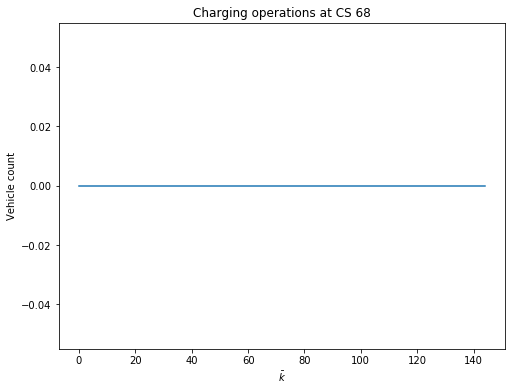

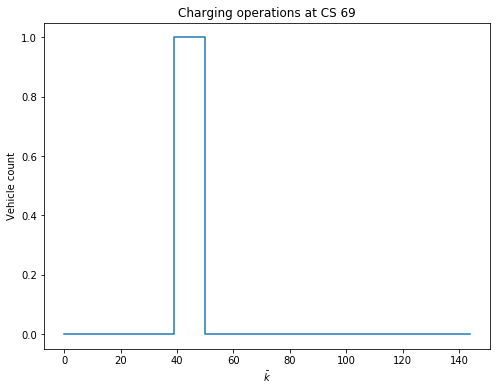

In [14]:
# %% Vehicles dynamics

# Vectors to plot

colorArrowTravel = 'SteelBlue'
colorArrowCharging = 'Crimson'
colorArrowServing = 'SeaGreen'

# Plot
maxTw = -1
minTw = 100000000000
for vehicleID, vehicle in vehiclesDict.items():
    # figures
    figX1 = figure(plot_width=600, plot_height=450,
                   title='Time the (vehicle '+str(vehicleID)+')',
                   toolbar_location=None)
    figX2 = figure(plot_width=600, plot_height=450,
                   title='SOC (vehicle '+str(vehicleID)+')',
                  y_range=(0, 100),
                  toolbar_location=None)
    figX3 = figure(plot_width=600, plot_height=450,
                   title='Payload (vehicle '+str(vehicleID)+')',
                  toolbar_location=None)
    
    # reaching leaving states for the vehicle
    reachingLeavingStates = leavingReachingSequences[vehicleID]

    # time windows
    nSeq = vehicle.nodeSequence
    kCustomers = []
    tWindowsUpper = []
    tWindowsLower = []
    for i, node in enumerate(nSeq):
        if networkDict[node].isCustomer():
            kCustomers.append(i)
            tWindowsCenter = (networkDict[node].timeWindowUp + networkDict[node].timeWindowDown) / 2.0
            tWindowsWidth =(networkDict[node].timeWindowUp - networkDict[node].timeWindowDown) / 2.0
            tWindowsUpper.append(tWindowsCenter + tWindowsWidth)
            tWindowsLower.append(tWindowsCenter - tWindowsWidth)
            # Time windows whiskers
            whiskerTW = Whisker(base=i, upper=tWindowsCenter + tWindowsWidth, lower=tWindowsCenter - tWindowsWidth)
            figX1.add_layout(whiskerTW)
            
            # update TW bounds
            if tWindowsCenter + tWindowsWidth > maxTw:
                maxTw = tWindowsCenter + tWindowsWidth
            if tWindowsCenter - tWindowsWidth < minTw:
                minTw = tWindowsCenter - tWindowsWidth
    
    # adjust fig 1 to fit TWs
    figX1.y_range=Range1d(minTw-10, maxTw+10)

    kVehicle = range(0, vehicle.si)

    figX1.line(kVehicle, reachingLeavingStates[0, :], alpha=0)
    figX1.line(kVehicle, reachingLeavingStates[1, :], alpha=0)
    figX2.line(kVehicle, reachingLeavingStates[2, :], alpha=0)
    figX2.line(kVehicle, reachingLeavingStates[3, :], alpha=0)
    figX3.line(kVehicle, reachingLeavingStates[4, :], alpha=0)

    reachingLeavingVectorPrev = reachingLeavingStates[:, 0]
    nodePrev = nSeq[0]
    kPrev = 0

    label = Label(x=kPrev, y=reachingLeavingVectorPrev[0], y_offset=-5, text=str(node), text_baseline='top')
    figX1.add_layout(label)

    label = Label(x=kPrev, y=reachingLeavingVectorPrev[2], y_offset=-5, text=str(node), text_baseline='top')
    figX2.add_layout(label)

    label = Label(x=kPrev, y=reachingLeavingVectorPrev[4], y_offset=-5, text=str(node), text_baseline='top')
    figX3.add_layout(label)
    
    # Axes
    figX1.xaxis.axis_label = 'k'
    figX1.yaxis.axis_label = 'Time of the day (min)'
    figX1.axis.axis_label_text_font_size = '15pt'
    figX1.axis.major_label_text_font_size = '13pt'
    figX1.title.text_font_size = '15pt'
    
    figX2.xaxis.axis_label = 'k'
    figX2.yaxis.axis_label = 'SOC (%)'
    figX2.axis.axis_label_text_font_size = '15pt'
    figX2.axis.major_label_text_font_size = '13pt'
    figX2.title.text_font_size = '15pt'
    
    figX3.xaxis.axis_label = 'k'
    figX3.yaxis.axis_label = 'Payload (ton)'
    figX3.axis.axis_label_text_font_size = '15pt'
    figX3.axis.major_label_text_font_size = '13pt'
    figX3.title.text_font_size = '15pt'
    
    # horizontal line SOC
    hline1 = Span(location=40, dimension='width', line_color='black')
    hline2 = Span(location=80, dimension='width', line_color='black')
    figX2.renderers.extend([hline1, hline2])
    
    
    for reachingLeavingVector, node, k in zip(reachingLeavingStates[:, 1:].T, nSeq[1:], range(1, vehicle.si)):
        # x1
        label = Label(x=k, y=reachingLeavingVector[0], y_offset=-5, text=str(node), text_baseline='top')
        figX1.add_layout(label)

        arrowTravel = Arrow(x_start=kPrev, y_start=reachingLeavingVectorPrev[1],
                            x_end=k, y_end=reachingLeavingVector[0],
                            end=VeeHead(size=8, fill_color=colorArrowTravel, line_color=colorArrowTravel),
                            line_color=colorArrowTravel, line_alpha=1)

        if networkDict[node].isChargeStation():
            colorArrowSpent = colorArrowCharging
        else:
            colorArrowSpent = colorArrowServing

        arrowSpent = Arrow(x_start=k, y_start=reachingLeavingVector[0],
                           x_end=k, y_end=reachingLeavingVector[1],
                           end=VeeHead(size=8, fill_color=colorArrowSpent, line_color=colorArrowSpent),
                           line_color=colorArrowSpent, line_alpha=1)

        figX1.add_layout(arrowTravel)
        figX1.add_layout(arrowSpent)

        # x2
        label = Label(x=k, y=reachingLeavingVector[3], y_offset=10, text=str(node), text_baseline='top')
        figX2.add_layout(label)

        arrowTravel = Arrow(x_start=kPrev, y_start=reachingLeavingVectorPrev[3],
                            x_end=k, y_end=reachingLeavingVector[2],
                            end=VeeHead(size=8, fill_color=colorArrowTravel, line_color=colorArrowTravel),
                            line_color=colorArrowTravel, line_alpha=1, line_width=1.5, visible=True)
        figX2.add_layout(arrowTravel)

        if networkDict[node].isChargeStation():
            colorArrowSpent = colorArrowCharging
            arrowSpent = Arrow(x_start=k, y_start=reachingLeavingVector[2],
                               x_end=k, y_end=reachingLeavingVector[3],
                               end=VeeHead(size=8, fill_color=colorArrowSpent, line_color=colorArrowSpent),
                               line_color=colorArrowSpent, line_alpha=1, line_width=1.5, visible=True)
            figX2.add_layout(arrowSpent)


        # x3
        label = Label(x=k, y=reachingLeavingVector[4], y_offset=-5, text=str(node), text_baseline='top')
        figX3.add_layout(label)

        if networkDict[nodePrev].isChargeStation():
            colorArrow = colorArrowCharging

        else:
            colorArrow = colorArrowTravel

        arrowTravel = Arrow(x_start=kPrev, y_start=reachingLeavingVectorPrev[4],
                            x_end=k, y_end=reachingLeavingVector[4],
                            end=VeeHead(size=8, fill_color=colorArrow, line_color=colorArrow),
                            line_color=colorArrow, line_alpha=1, line_width=1.5, visible=True)
        figX3.add_layout(arrowTravel)

        # common
        reachingLeavingVectorPrev = reachingLeavingVector
        nodePrev = node
        kPrev = k
        
    # Save
    export_png(figX1, filename=figureFolderPath+"x1_vehicle"+str(vehicleID)+".png")
    
    export_png(figX2, filename=figureFolderPath+"x2_vehicle"+str(vehicleID)+".png")
    
    export_png(figX3, filename=figureFolderPath+"x3_vehicle"+str(vehicleID)+".png")   
    
    
    # Show
    show(figX1)
    show(figX2)
    show(figX3)

# %% Plot results for CSs
for cs in networkDict['CS_LIST']:
    fig = plt.figure(figsize=(8, 6))
    csID = cs.id
    counter = thetaMatrix[csID, :]
    plt.step(np.arange(len(counter)), counter)
    plt.title('Charging operations at CS ' + str(csID))
    plt.xlabel(r'$\bar{k}$')
    plt.ylabel('Vehicle count')
    plt.savefig(figureFolderPath+"CS_"+str(cs.id)+".png")
    plt.show()


In [15]:
# %% Time of execution
tEnd = time.time()
print("Total execution time:", (tEnd - t0) * 1000.0, "ms")

Total execution time: 572053.1716346741 ms
